

## Analysing the booking completetion of booking tickets
### Problem statement and Scope
Airline and travel booking platforms often experience a significant number of incomplete bookings — customers start the booking process (selecting routes, seats, and preferences) but abandon before final payment.
This project aims to predict whether a booking will be completed using historical booking data containing features like purchase lead time, travel routes, flight durations, and seat preferences.

By identifying factors that influence booking completion, the business can:

Optimize the booking process to reduce drop-offs.

Target at-risk customers with personalized reminders or offers.

Improve marketing ROI by focusing on high-likelihood customers.

Goal: Build a machine learning model that predicts booking completion with high accuracy, while ensuring interpretability for business stakeholders.

Success Criteria:

Primary: Achieve at least 85% accuracy or 0.85 F1-score on test data.

Secondary: Identify the top 5 most influential factors affecting booking completion.


### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows',30)        


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
print(" statistical information of the dataset")
df.describe()

 statistical information of the dataset


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.



### initial data exposoition

##setting columns and other basic statistics and spliting of dataset


In [8]:
# categorical=['sales_channel','trip_type','route','booking_origin']
# numerical=['num_passengers','purchase_lead','length_of_stay','flight_hour','flight_duration']
# numerised_categoricals=['flight_day','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals','booking_complete']

array([[<Axes: title={'center': 'num_passengers'}>,
        <Axes: title={'center': 'purchase_lead'}>,
        <Axes: title={'center': 'length_of_stay'}>],
       [<Axes: title={'center': 'flight_hour'}>,
        <Axes: title={'center': 'flight_day'}>,
        <Axes: title={'center': 'wants_extra_baggage'}>],
       [<Axes: title={'center': 'wants_preferred_seat'}>,
        <Axes: title={'center': 'wants_in_flight_meals'}>,
        <Axes: title={'center': 'flight_duration'}>],
       [<Axes: title={'center': 'booking_complete'}>, <Axes: >, <Axes: >]],
      dtype=object)

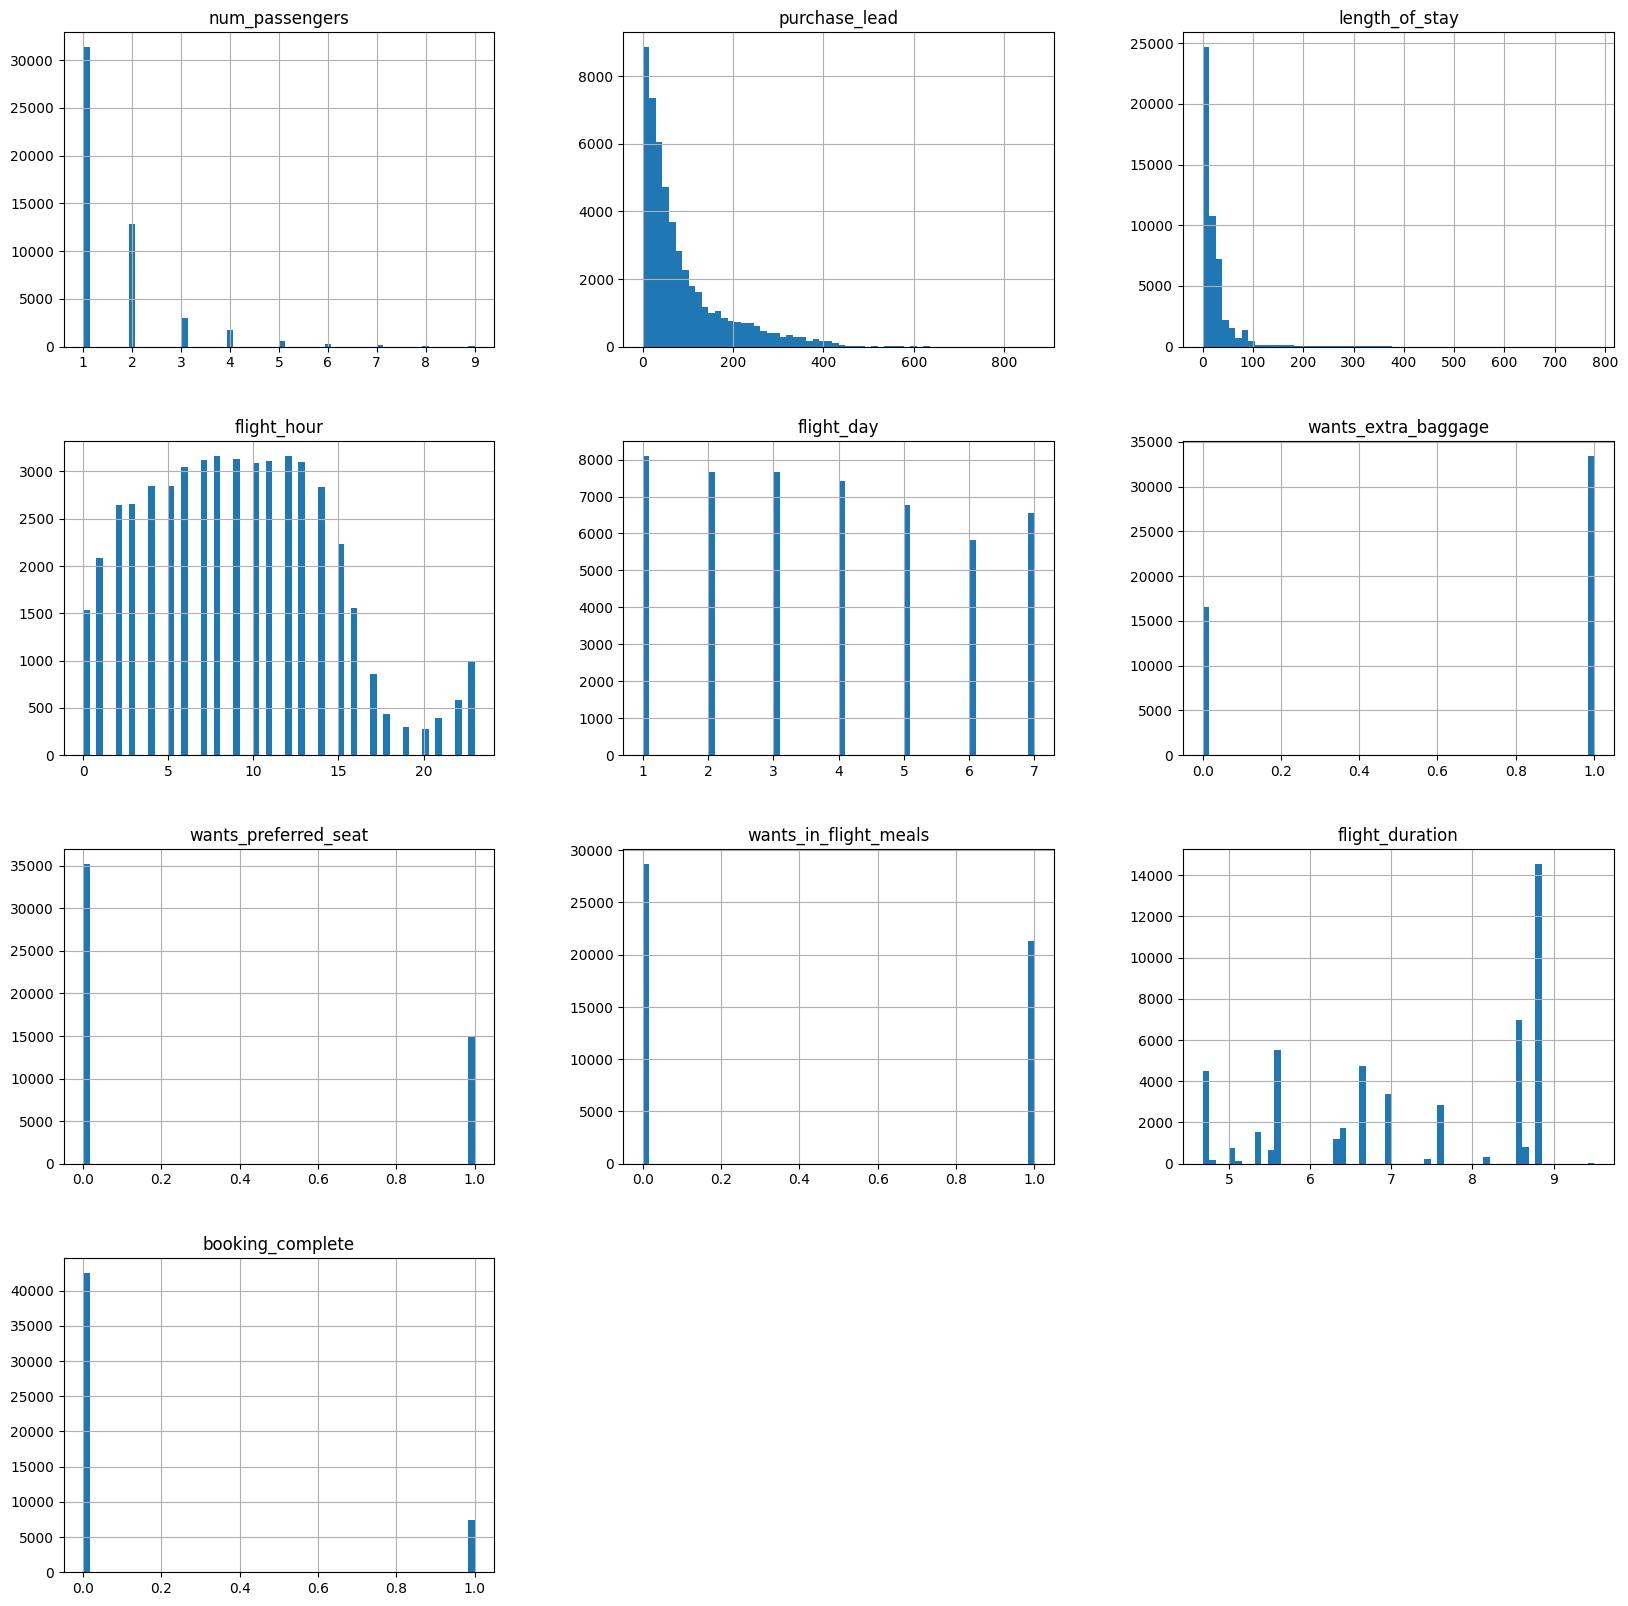

In [9]:
df.hist(bins=60,figsize=(20,20))

In [10]:

complete=df[df['booking_complete']==1]
booking_not_complete=df[df['booking_complete']==0]

### Pie chart  showing the percent of booking completed to not completed in the total bookings began

<Axes: ylabel='count'>

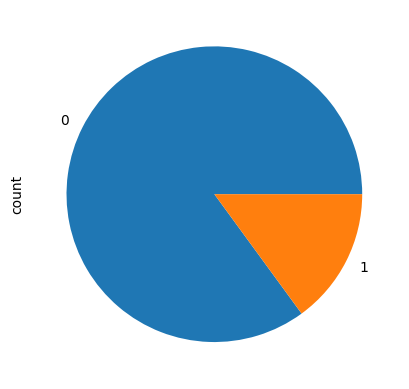

In [11]:
df['booking_complete'].value_counts().plot(kind='pie')

### Bar chart   showing the percent of booking completed to not completed in the total bookings 
#### from the chart and subsequent calculation we can infer that 14.956% of bookings were completed while 85.044% of bookings were not completed

In [53]:
count_complete=df[df['booking_complete']==1].shape[0]
count_not_complete=df[df['booking_complete']==0].shape[0]
total=df.shape[0]
percentage_complete=(count_complete/total)*100
percentage_not_complete=(count_not_complete/total)*100
print(f'{percentage_complete}% of bookings were completed while {percentage_not_complete}% of bookings were not completed')

14.956% of bookings were completed while 85.044% of bookings were not completed


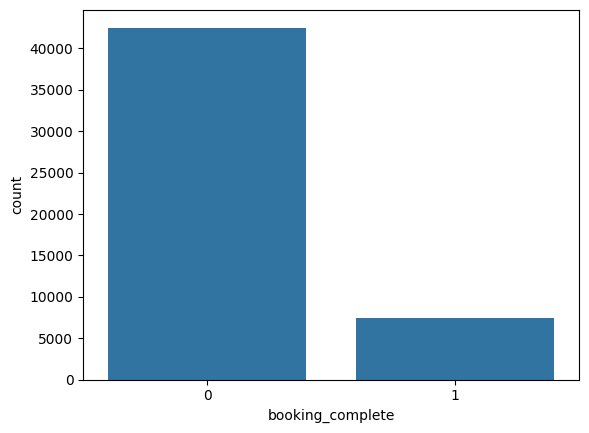

In [12]:
sns.countplot(x='booking_complete',data=df)
plt.show()

### Histograms showing the distribution of the  columns in the datset

#### From the histogram we can infer that purchase lead time of 0-200 days(mostly 0 days)  have significantly higher bookings 

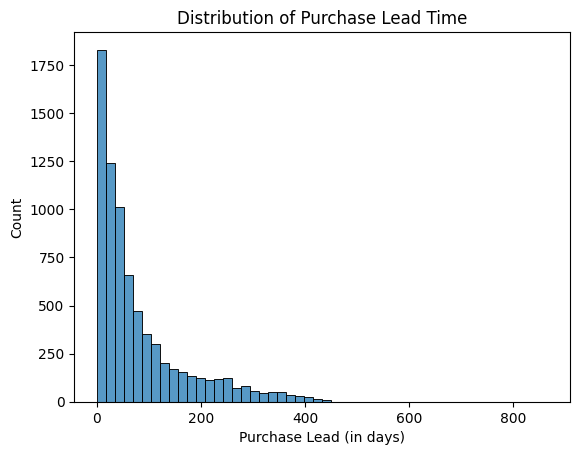

In [13]:
sns.histplot(data=complete, x='purchase_lead', bins=50)
plt.title('Distribution of Purchase Lead Time')
plt.xlabel('Purchase Lead (in days)')
plt.ylabel('Count')
plt.show()

#### flights between early mornings and evenings have more bookings

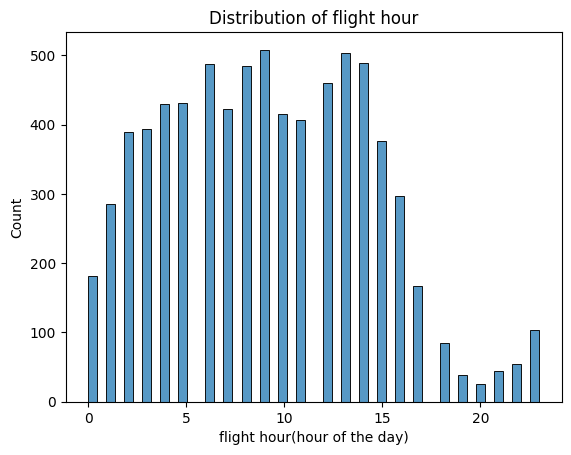

In [14]:
sns.histplot(data=complete, x='flight_hour', bins=50)
plt.title('Distribution of flight hour')
plt.xlabel('flight hour(hour of the day)')
plt.ylabel('Count')
plt.show()

#### length of stay of about 1-100 days are mostly booked,where 1 day of stay has significantly higher bookings

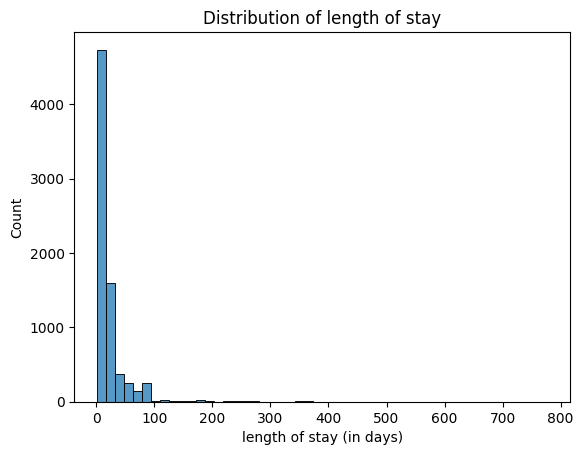

In [15]:
sns.histplot(data=complete, x='length_of_stay', bins=50)
plt.title('Distribution of length of stay')
plt.xlabel('length of stay (in days)')
plt.ylabel('Count')
plt.show()

#### The number of passengers most booked are 1 passenger(significantly higher) followed by 2 and then 3

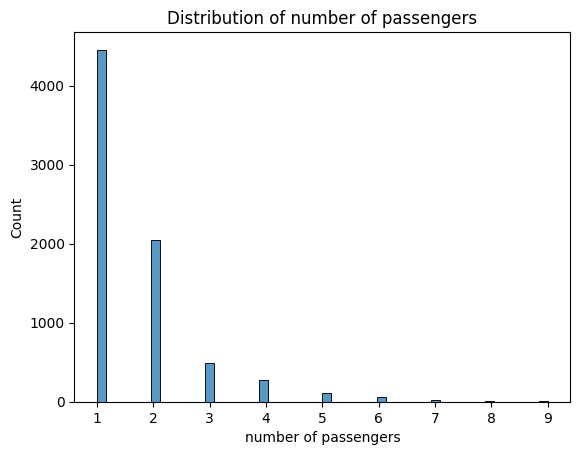

In [16]:
sns.histplot(data=complete, x='num_passengers', bins=50)
plt.title('Distribution of number of passengers')
plt.xlabel('number of passengers')
plt.ylabel('Count')
plt.show()

#### Flights that fly for 8-9 hours have more bookingsfollowed by 3-6 hours

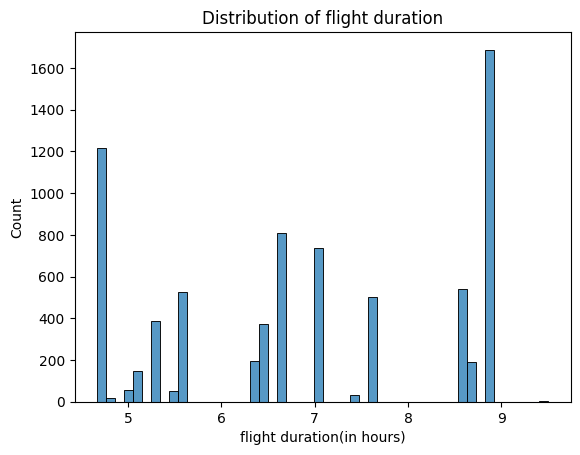

In [17]:
sns.histplot(data=complete, x='flight_duration', bins=50)
plt.title('Distribution of flight duration')
plt.xlabel('flight duration(in hours)')
plt.ylabel('Count')
plt.show()

#### Round trip is the most booked (by a really significant amount) trip type

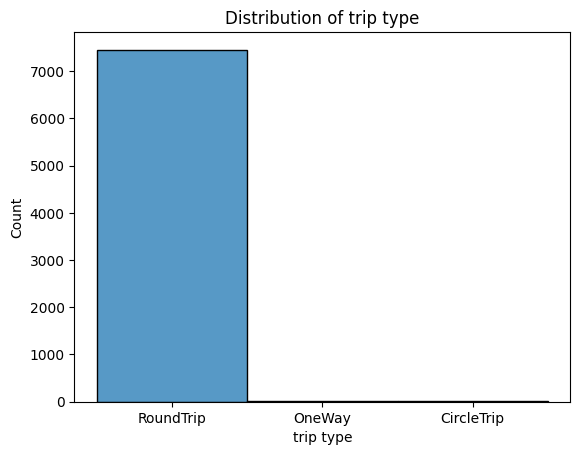

In [18]:
sns.histplot(data=complete, x='trip_type', bins=50)
plt.title('Distribution of trip type')
plt.xlabel('trip type')
plt.ylabel('Count')
plt.show()

#### most flights are booked on wednesday followed by monday and tuesday and thursday

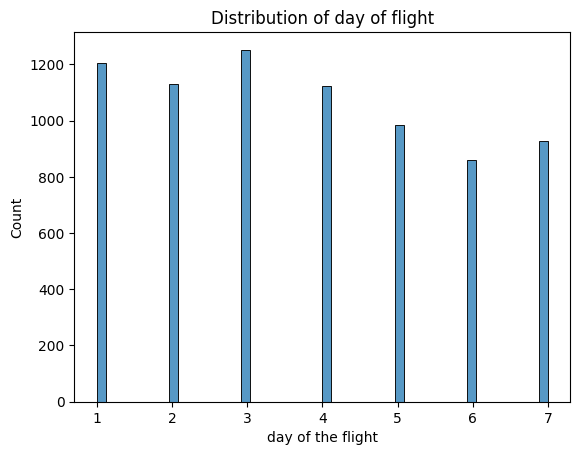

In [19]:
sns.histplot(data=complete, x='flight_day', bins=50)
plt.title('Distribution of day of flight')
plt.xlabel('day of the flight')
plt.ylabel('Count')
plt.show()

#### The most booked routes are AKLKUL followed by PENTPE

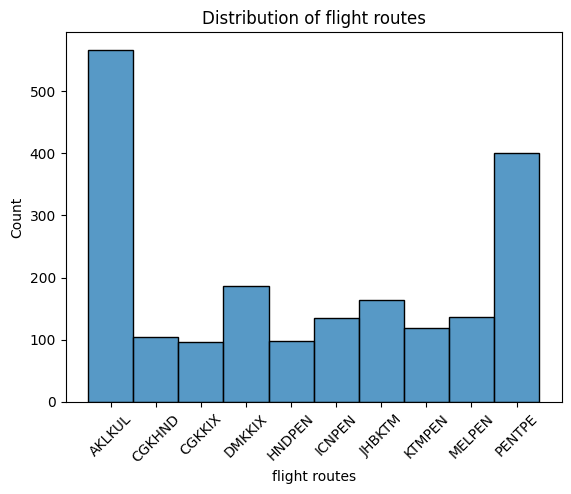

In [24]:
routes=complete['route'].value_counts().head(10).index
top_routes=complete[complete['route'].isin(routes)]
sns.histplot(data=top_routes, x='route', bins=50)
plt.title('Distribution of flight routes')
plt.xlabel('flight routes')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

#### Malaysia is the country from where most bookings are completed followed by Australia

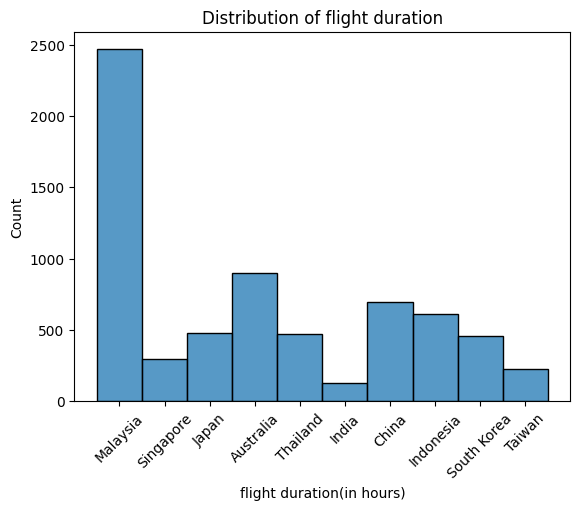

In [28]:
origin=complete['booking_origin'].value_counts().head(10).index
top_origin=complete[complete['booking_origin'].isin(origin)]
sns.histplot(data=top_origin, x='booking_origin', bins=50)
plt.title('Distribution of flight duration')
plt.xlabel('flight duration(in hours)')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

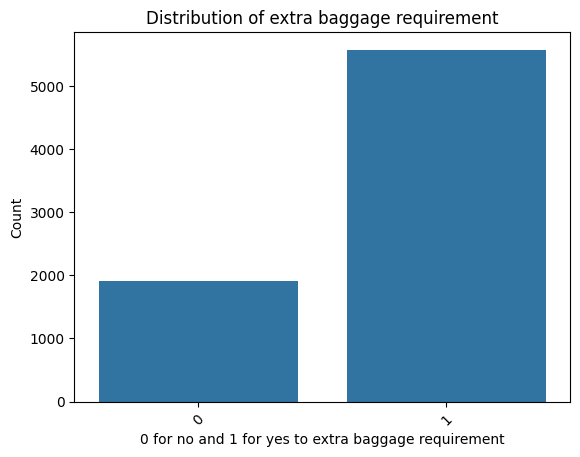

In [32]:
sns.countplot(data=complete, x='wants_extra_baggage')
plt.title('Distribution of extra baggage requirement')
plt.xlabel('0 for no and 1 for yes to extra baggage requirement')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

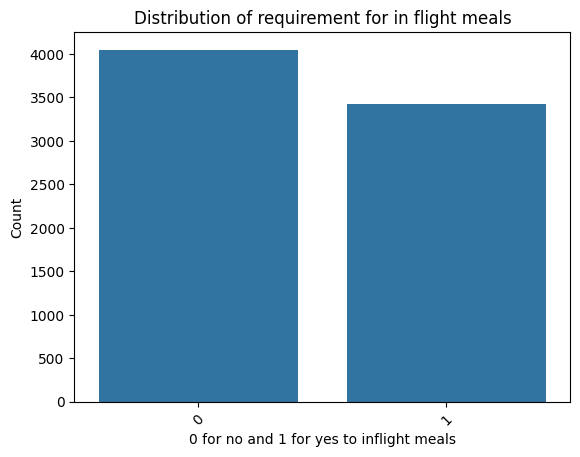

In [34]:
sns.countplot(data=complete, x='wants_in_flight_meals')
plt.title('Distribution of requirement for in flight meals')
plt.xlabel('0 for no and 1 for yes to inflight meals')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

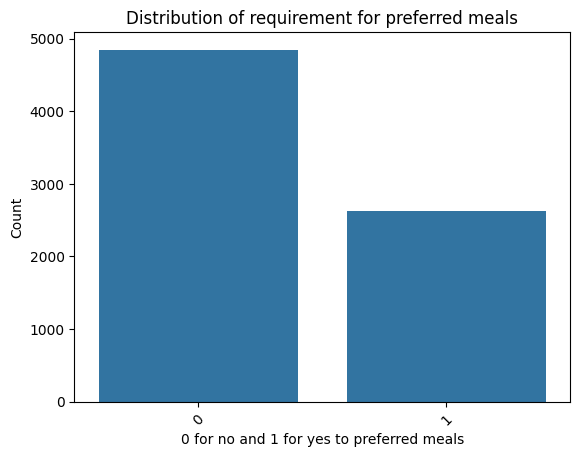

In [37]:
sns.countplot(data=complete, x='wants_preferred_seat')
plt.title('Distribution of requirement for preferred meals')
plt.xlabel('0 for no and 1 for yes to preferred meals')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

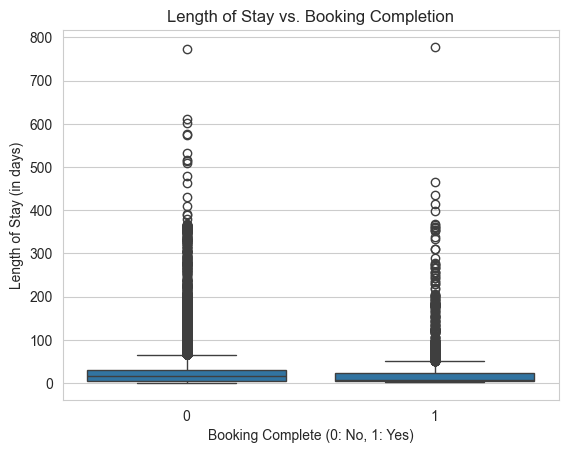

In [ ]:
sns.boxplot(x='booking_complete', y='length_of_stay', data=df)
plt.title('Length of Stay vs. Booking Completion')
plt.xlabel('Booking Complete (0: No, 1: Yes)')
plt.ylabel('Length of Stay (in days)')
plt.show()

In [ ]:
complete['flight_day'].value_counts()

flight_day
3    1252
1    1204
2    1129
4    1122
5     983
7     927
6     861
Name: count, dtype: int64

In [ ]:
complete['flight_hour'].value_counts()

flight_hour
9     508
13    503
14    489
6     488
8     484
12    460
5     431
4     430
7     423
10    415
11    407
3     393
2     389
15    376
16    297
1     285
0     182
17    167
23    103
18     85
22     54
21     45
19     39
20     25
Name: count, dtype: int64

In [ ]:
complete['flight_duration'].value_counts()

flight_duration
8.83    1688
6.62     810
7.00     738
4.67     675
8.58     542
5.62     525
7.57     500
4.75     419
5.33     386
6.42     372
6.33     195
8.67     189
5.07     121
4.72     121
5.00      58
5.52      52
7.42      34
5.13      28
4.83      19
9.50       5
8.15       1
Name: count, dtype: int64

In [ ]:
complete['length_of_stay'].value_counts()

length_of_stay
6      1613
5      1370
4      1039
3       506
17      197
       ... 
289       1
116       1
119       1
365       1
132       1
Name: count, Length: 180, dtype: int64

In [ ]:
complete['purchase_lead'].value_counts()

purchase_lead
7      122
4      121
2      120
6      118
13     117
      ... 
381      1
354      1
417      1
867      1
390      1
Name: count, Length: 424, dtype: int64

In [ ]:
complete['route'].value_counts()

route
AKLKUL    567
PENTPE    401
DMKKIX    187
JHBKTM    164
MELPEN    137
         ... 
AKLPVG      1
MELNRT      1
MELMLE      1
NRTSYD      1
OOLUTP      1
Name: count, Length: 549, dtype: int64

In [ ]:
complete['trip_type'].value_counts()

trip_type
RoundTrip     7453
OneWay          20
CircleTrip       5
Name: count, dtype: int64

In [ ]:
complete['wants_preferred_seat'].value_counts()
complete['wants_in_flight_meals'].value_counts()
complete['wants_preferred_seat'].value_counts()

wants_preferred_seat
0    4849
1    2629
Name: count, dtype: int64

### Bivariate Analysis

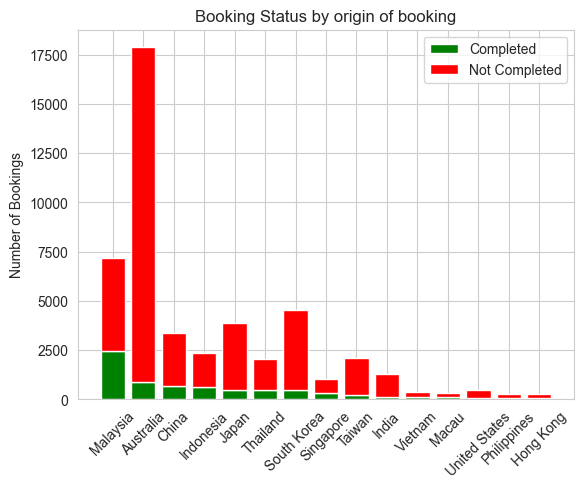

In [ ]:
booking_origin=complete['booking_origin'].value_counts().head(15).index.to_list()
completed_counts=complete['booking_origin'].value_counts()
not_booked_counts=booking_not_complete['booking_origin'].value_counts()

completed=[completed_counts.get(label,0) for label in  booking_origin]
not_booked=[not_booked_counts.get(label,0) for label in  booking_origin]
x = range(len(booking_origin))
plt.bar(x, completed, label='Completed', color='green')
plt.bar(x, not_booked, bottom=completed, label='Not Completed', color='red')

# Labeling
plt.Figure(figsize=(20,20))
plt.xticks(x, booking_origin,rotation=45)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by origin of booking')
plt.legend()
plt.show()

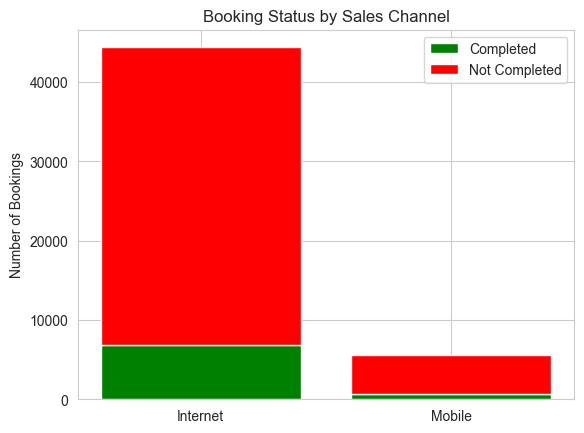

In [ ]:
import matplotlib.pyplot as plt


completed_counts = complete['sales_channel'].value_counts()


not_completed_counts = booking_not_complete['sales_channel'].value_counts()


labels = ['Internet', 'Mobile']
completed = [completed_counts.get(label, 0) for label in labels]
not_completed = [not_completed_counts.get(label, 0) for label in labels]

# Plot stacked bar chart
x = range(len(labels))
plt.bar(x, completed, label='Completed', color='green')
plt.bar(x, not_completed, bottom=completed, label='Not Completed', color='red')

# Labeling
plt.xticks(x, labels)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by Sales Channel')
plt.legend()
plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '9'),
  Text(8, 0, '8')])

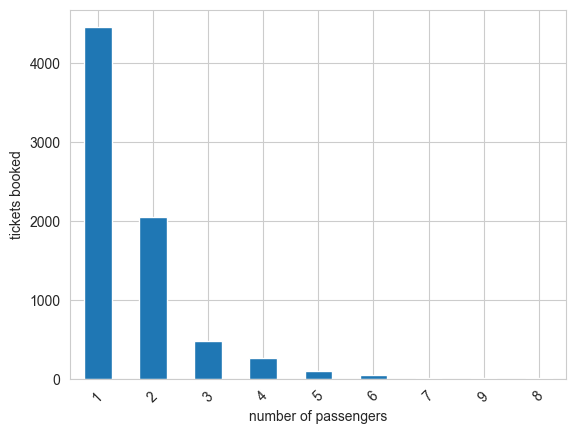

In [ ]:
complete['num_passengers'].value_counts().plot(kind="bar")
sns.set_style('whitegrid')
plt.xlabel("number of passengers")
plt.ylabel("tickets booked")
plt.xticks(rotation=45)

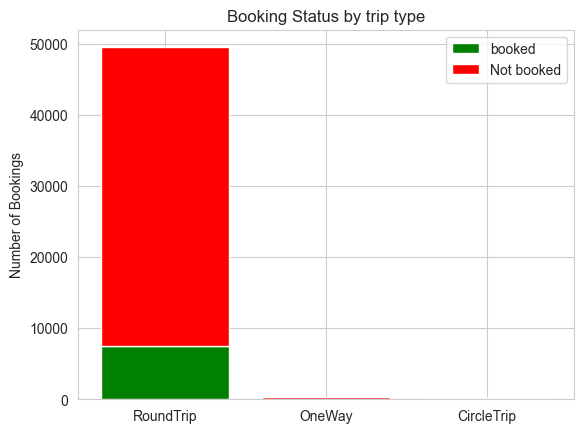

In [ ]:
completed_counts=complete['trip_type'].value_counts()
not_booked_counts=booking_not_complete['trip_type'].value_counts()
labels=['RoundTrip','OneWay','CircleTrip']
completed=[completed_counts.get(label,0) for label in  labels]
not_booked=[not_booked_counts.get(label,0) for label in  labels]
x = range(len(labels))
plt.bar(x, completed, label='booked', color='green')
plt.bar(x, not_booked, bottom=completed, label='Not booked', color='red')

# Labeling
plt.xticks(x, labels)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by trip type')
plt.legend()
plt.show()

In [ ]:
complete['route'].value_counts().index

Index(['AKLKUL', 'PENTPE', 'DMKKIX', 'JHBKTM', 'MELPEN', 'ICNPEN', 'KTMPEN', 'CGKHND', 'HNDPEN', 'CGKKIX',
       ...
       'CKGKNO', 'CKGSIN', 'CTSJOG', 'CTSHKT', 'CTSKBR', 'AKLPVG', 'MELNRT', 'MELMLE', 'NRTSYD', 'OOLUTP'], dtype='object', name='route', length=549)

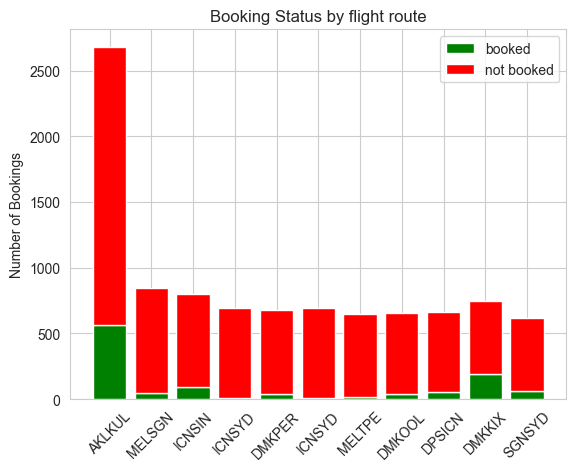

In [ ]:
completed_counts=complete['route'].value_counts()
not_booked_counts=booking_not_complete['route'].value_counts()
label=['AKLKUL','MELSGN','ICNSIN','ICNSYD','DMKPER','ICNSYD', 'MELTPE', 'DMKOOL', 'DPSICN', 'DMKKIX', 'SGNSYD',]
booked=[completed_counts.get(labels,0) for labels in label]
not_booked=[not_booked_counts.get(labels,0)for labels in label]
x=range(len(label))
plt.Figure(figsize=(20,20))
plt.bar(x,booked,label='booked',color='green')
plt.bar(x,not_booked,bottom=booked,label='not booked',color='red')
plt.xticks(x,label,rotation=45)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by flight route')
plt.legend()
plt.show()



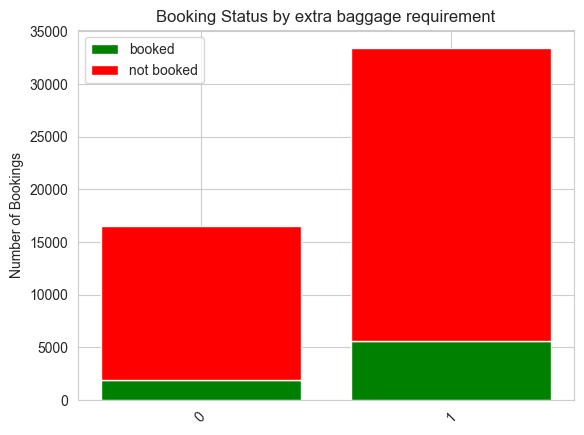

In [ ]:
completed_counts=complete['wants_extra_baggage'].value_counts()
not_booked_counts=booking_not_complete['wants_extra_baggage'].value_counts()
label=[0,1]
booked=[completed_counts.get(labels,0) for labels in label]
not_booked=[not_booked_counts.get(labels,0)for labels in label]
x=range(len(label))
plt.Figure(figsize=(20,20))
plt.bar(x,booked,label='booked',color='green')
plt.bar(x,not_booked,bottom=booked,label='not booked',color='red')
plt.xticks(x,label,rotation=45)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by extra baggage requirement')
plt.legend()
plt.show()

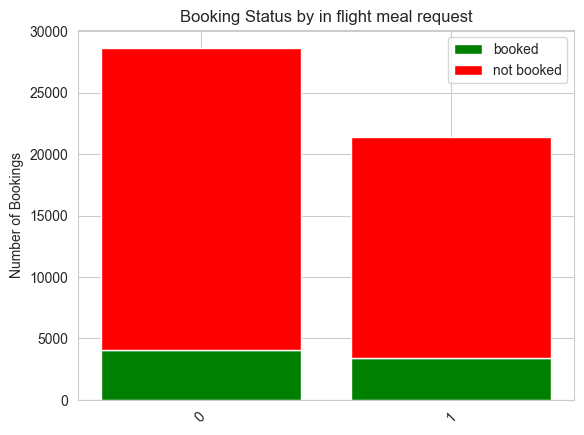

In [ ]:
completed_counts=complete['wants_in_flight_meals'].value_counts()
not_booked_counts=booking_not_complete['wants_in_flight_meals'].value_counts()
label=[0,1]
booked=[completed_counts.get(labels,0) for labels in label]
not_booked=[not_booked_counts.get(labels,0)for labels in label]
x=range(len(label))
plt.Figure(figsize=(20,20))
plt.bar(x,booked,label='booked',color='green')
plt.bar(x,not_booked,bottom=booked,label='not booked',color='red')
plt.xticks(x,label,rotation=45)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by in flight meal request')
plt.legend()
plt.show()

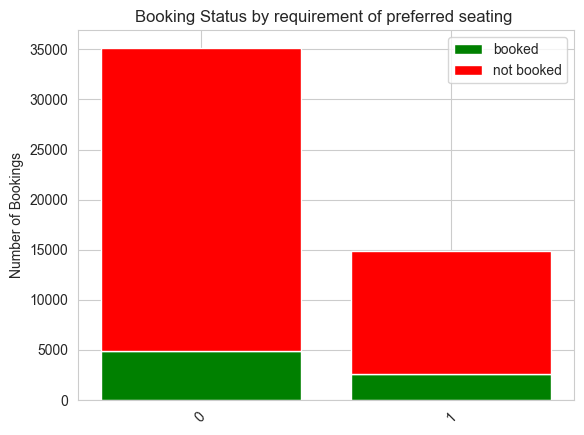

In [ ]:
completed_counts=complete['wants_preferred_seat'].value_counts()
not_booked_counts=booking_not_complete['wants_preferred_seat'].value_counts()
label=[0,1]
booked=[completed_counts.get(labels,0) for labels in label]
not_booked=[not_booked_counts.get(labels,0)for labels in label]
x=range(len(label))
plt.Figure(figsize=(20,20))
plt.bar(x,booked,label='booked',color='green')
plt.bar(x,not_booked,bottom=booked,label='not booked',color='red')
plt.xticks(x,label,rotation=45)
plt.ylabel('Number of Bookings')
plt.title('Booking Status by requirement of preferred seating ')
plt.legend()
plt.show()

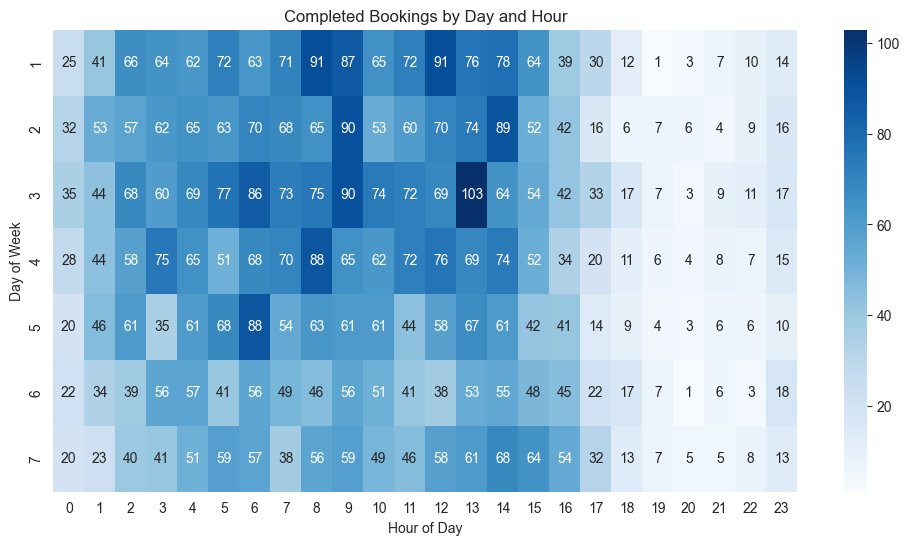

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


hour_booking=complete.groupby(['flight_day','flight_hour'])['booking_complete'].sum().reset_index()
top_hours=hour_booking.sort_values(by='booking_complete',ascending=False).head(40)


# Pivot for heatmap
pivot_table = hour_booking.pivot(index='flight_day', columns='flight_hour', values='booking_complete')

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".0f")
plt.title('Completed Bookings by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

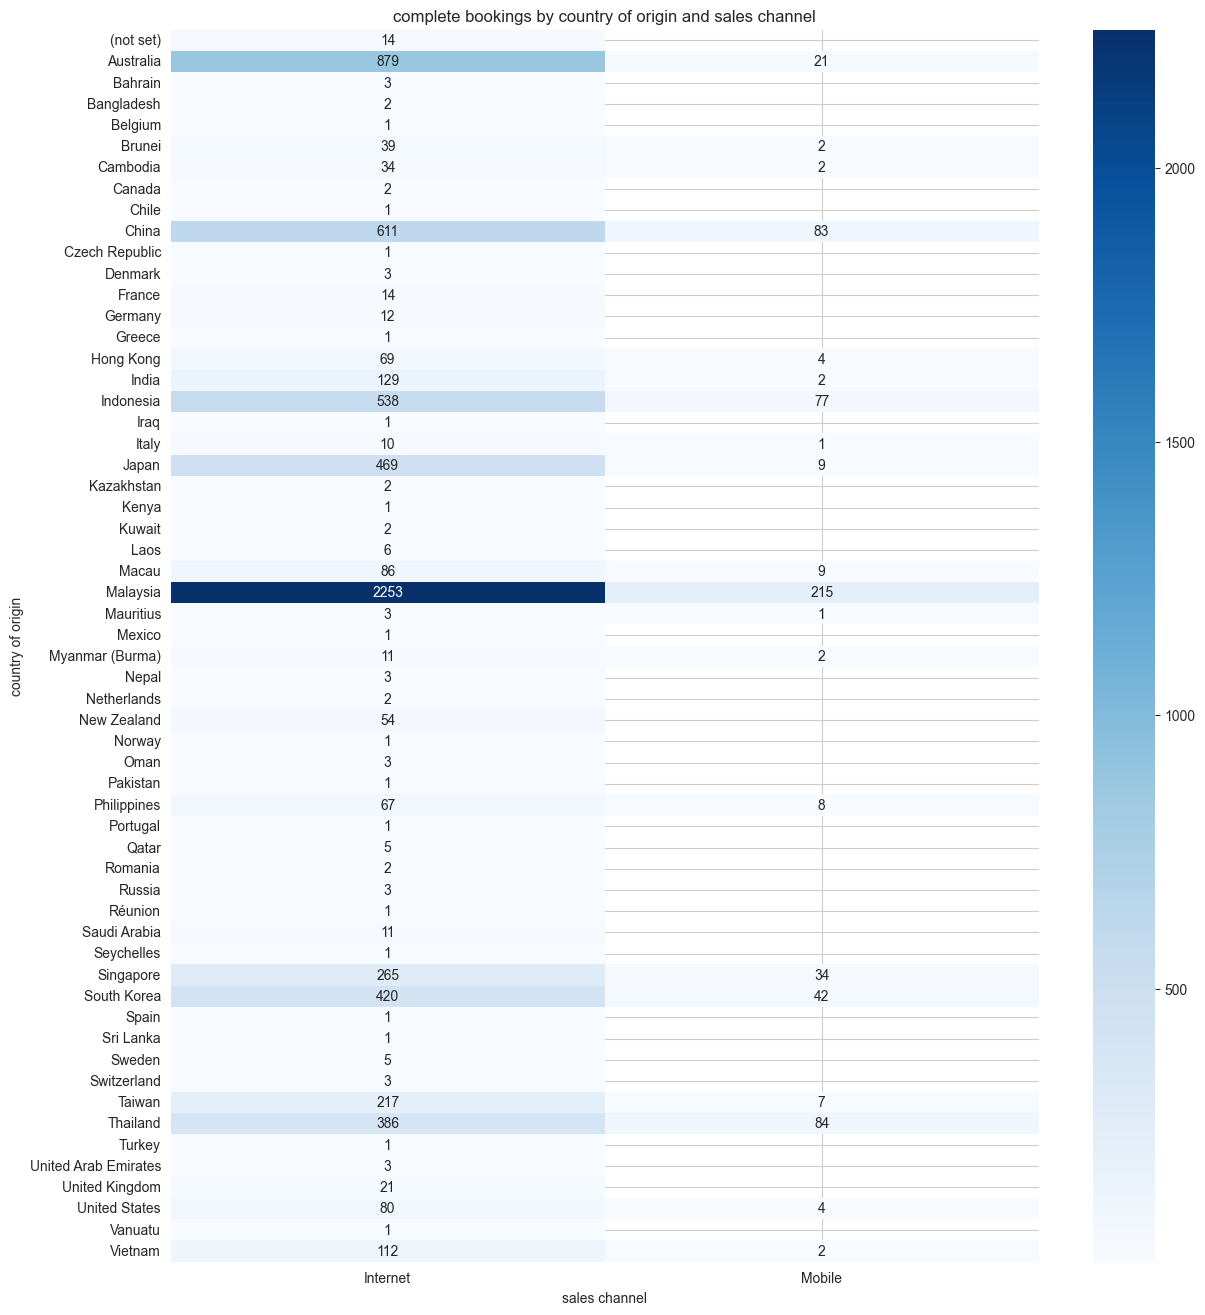

In [ ]:

origin_sales=complete.groupby(['booking_origin','sales_channel'])['booking_complete'].sum().reset_index()
top_sales=origin_sales.sort_values(by='booking_complete',ascending=False).head(10)
pivot_table=origin_sales.pivot(index='booking_origin',columns='sales_channel',values='booking_complete')
plt.figure(figsize=(14,16))
sns.heatmap(pivot_table,cmap='Blues',annot=True,fmt=".0f")
plt.title('complete bookings by country of origin and sales channel')
plt.ylabel("country of origin")
plt.xlabel('sales channel')
plt.show()


In [38]:
# top_routes=complete['route'].value_counts().head(10).index
# df_routes=complete[complete['route'].isin(top_routes)]
# routes_sales=df_routes.groupby(['route','sales_channel'])['booking_complete'].sum().reset_index()
# top_sales=routes_sales.sort_values(by='booking_complete',ascending=False).head(10)
# pivot_table=origin_sales.pivot(index='route',columns='sales_channel',values='booking_complete')
# plt.figure(figsize=(14,16))
# sns.heatmap(pivot_table,cmap='Blues',annot=True,fmt=".0f")
# plt.title('complete bookings by country of origin and sales channel')
# plt.xlabel('sales channel')
# plt.ylabel('flight routes')
# plt.show()


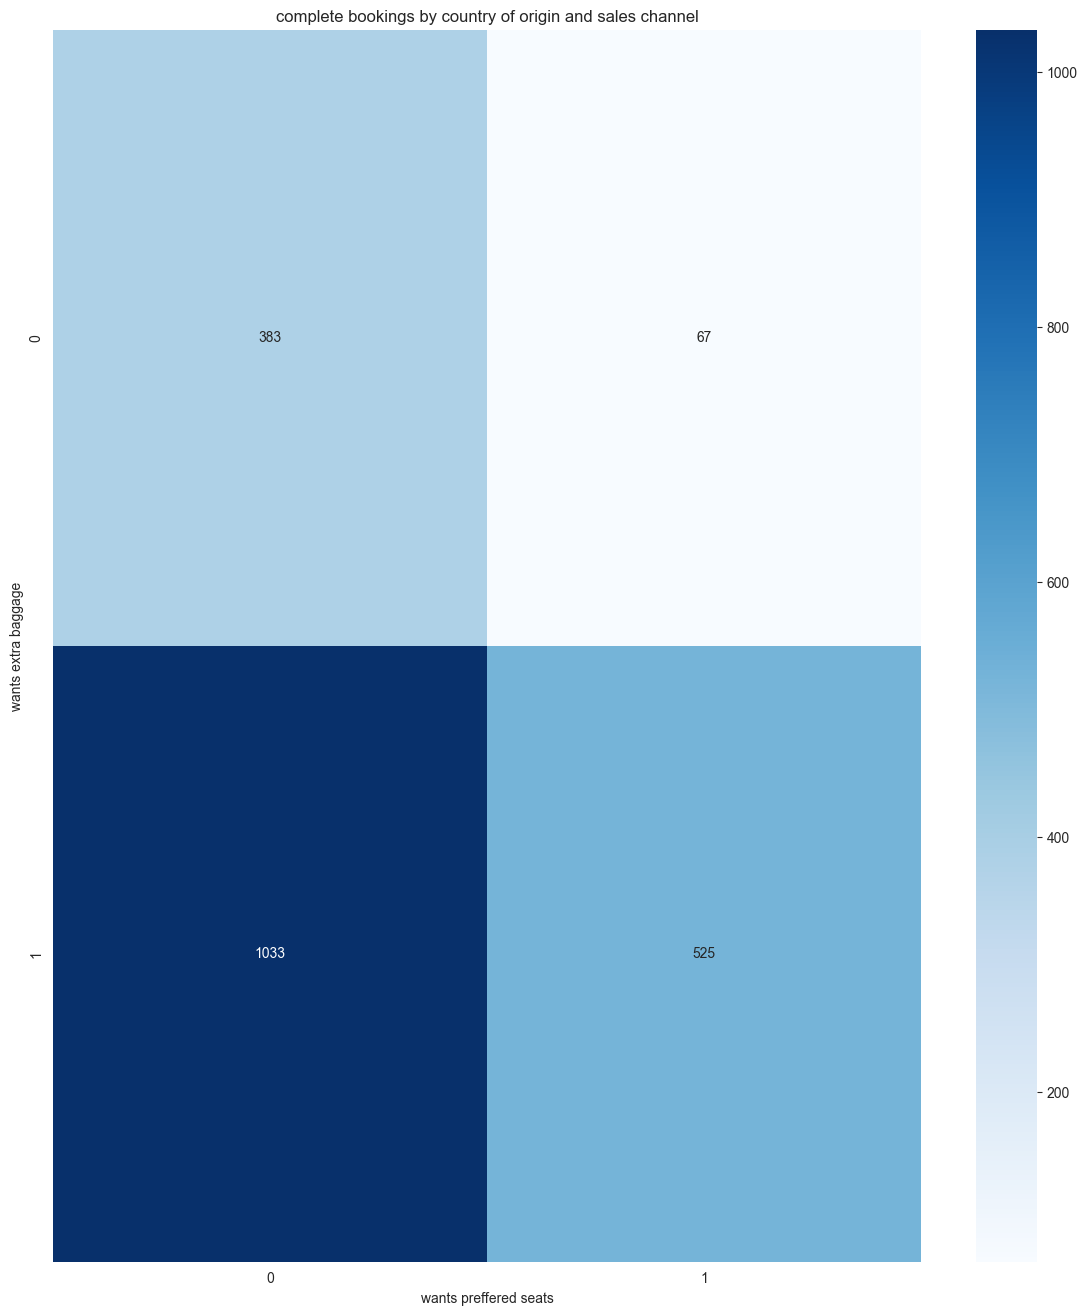

In [ ]:

origin_sales=df_routes.groupby(['wants_extra_baggage','wants_preferred_seat'])['booking_complete'].sum().reset_index()
top_sales=origin_sales.sort_values(by='booking_complete',ascending=False).head(10)
pivot_table=origin_sales.pivot(index='wants_extra_baggage',columns='wants_preferred_seat',values='booking_complete')
plt.figure(figsize=(14,16))
sns.heatmap(pivot_table,cmap='Blues',annot=True,fmt=".0f")
plt.title('complete bookings by ')
plt.xlabel('wants preffered seats')
plt.ylabel('wants extra baggage')
plt.show()


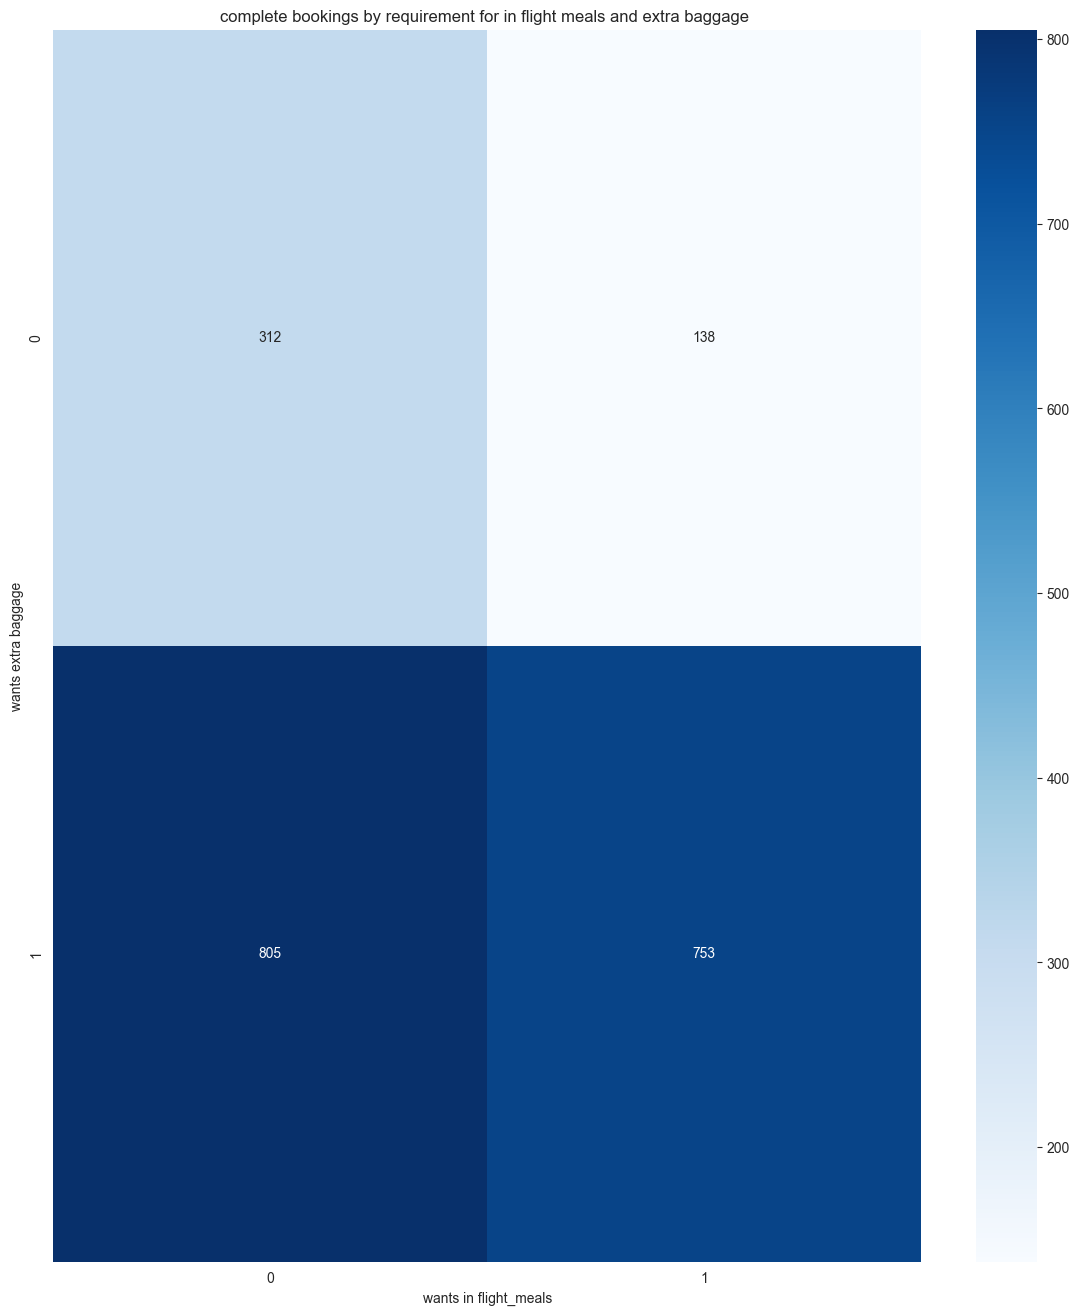

In [ ]:
origin_sales=df_routes.groupby(['wants_extra_baggage','wants_in_flight_meals'])['booking_complete'].sum().reset_index()
top_sales=origin_sales.sort_values(by='booking_complete',ascending=False).head(10)
pivot_table=origin_sales.pivot(index='wants_extra_baggage',columns='wants_in_flight_meals',values='booking_complete')
plt.figure(figsize=(14,16))
sns.heatmap(pivot_table,cmap='Blues',annot=True,fmt=".0f")
plt.title('complete bookings by requirement for in flight meals and extra baggage ')
plt.xlabel('wants in flight_meals')
plt.ylabel('wants extra baggage')
plt.show()

<Axes: xlabel='flight_hour'>

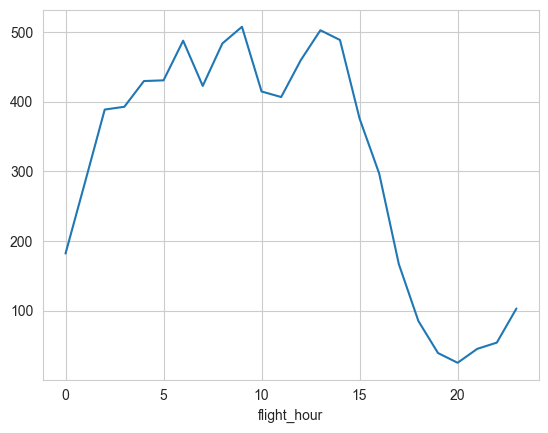

In [ ]:
df.groupby('flight_hour')['booking_complete'].sum().plot()

<Axes: xlabel='flight_day'>

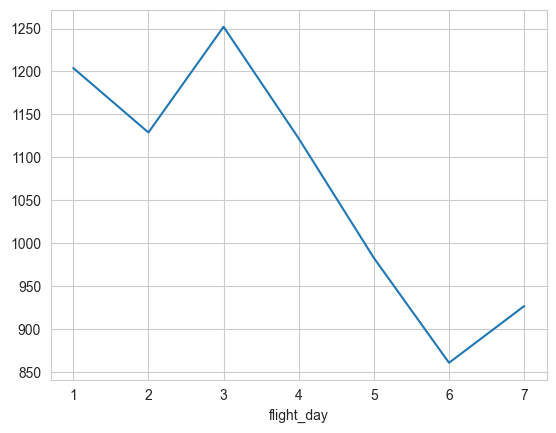

In [ ]:
df.groupby('flight_day')['booking_complete'].sum().plot()

<Axes: xlabel='flight_duration'>

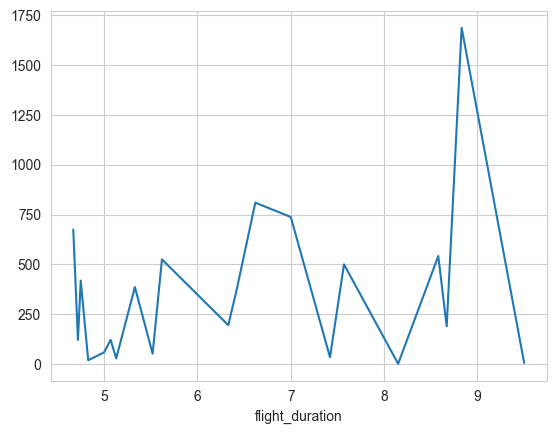

In [ ]:
df.groupby('flight_duration')['booking_complete'].sum().plot()

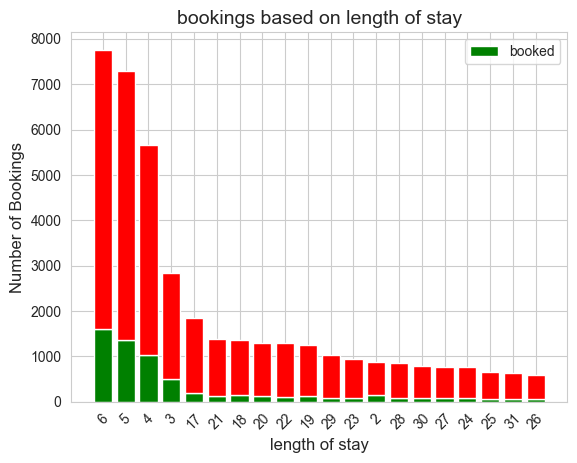

In [ ]:
length_of_stay=df['length_of_stay'].value_counts().head(20).index.to_list()

completed_counts= complete['length_of_stay'].value_counts()
not_completed_counts= booking_not_complete['length_of_stay'].value_counts()
booked=[completed_counts.get(labels,0) for labels in length_of_stay]
not_booked=[not_completed_counts.get(labels,0) for labels in length_of_stay]
x=range(len(length_of_stay))
plt.bar(x,booked,label='booked',color='green')
plt.bar(x,not_booked,bottom=booked,color='red')

plt.title('bookings based on length of stay', fontsize=14)
plt.xlabel('length of stay', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(x,length_of_stay,rotation=45)
plt.legend()


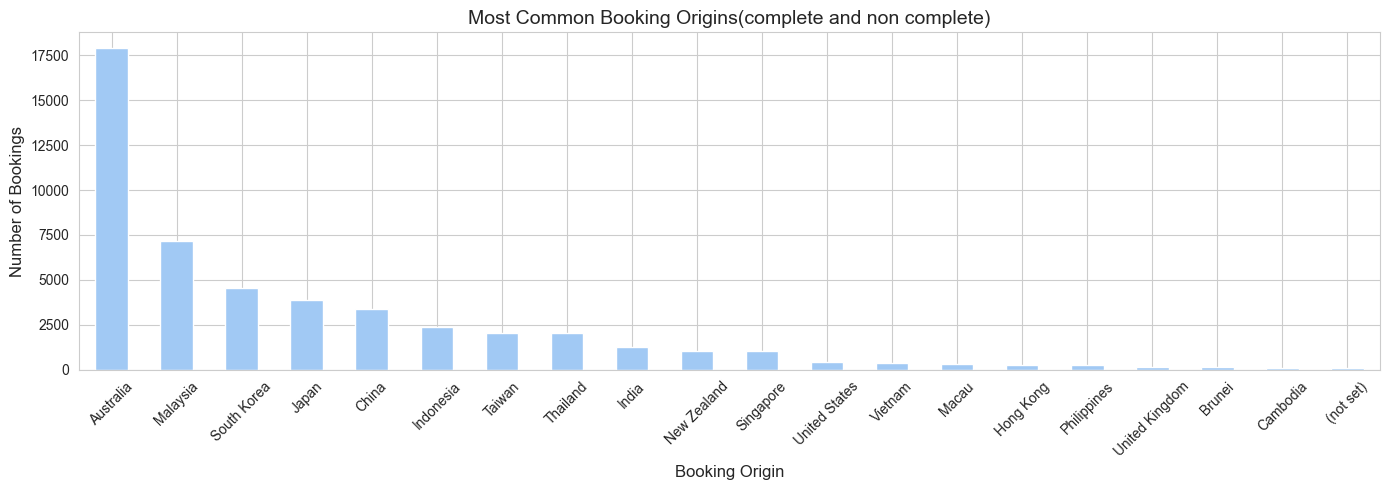

In [ ]:


booking_complete = df['booking_origin'].value_counts()


sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(14, 5))
booking_complete.head(20).plot(kind='bar')

plt.title('Most Common Booking Origins(complete and non complete)', fontsize=14)
plt.xlabel('Booking Origin', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

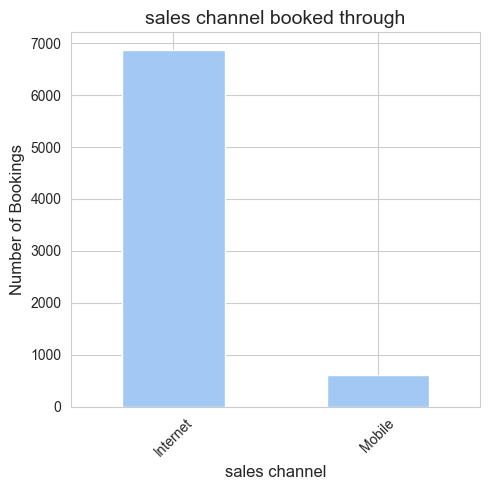

In [ ]:


booking_complete = df[df['booking_complete'] == 1]
sales_channel_booked = booking_complete['sales_channel'].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(5, 5))
sales_channel_booked.head(20).plot(kind='bar')

plt.title('sales channel booked through', fontsize=14)
plt.xlabel('sales channel', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

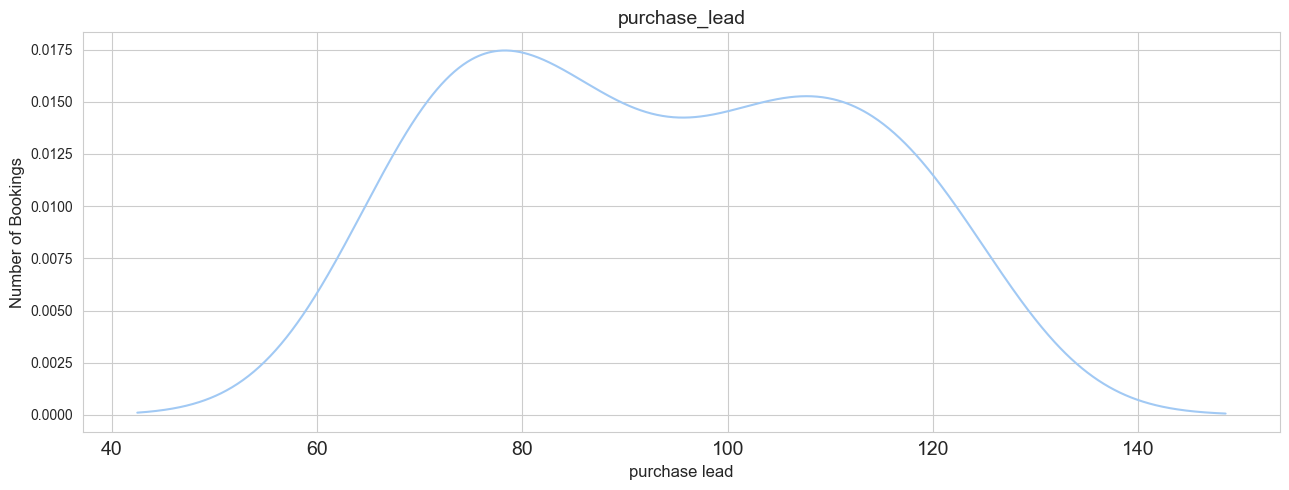

In [ ]:

booking_complete = df[df['booking_complete'] == 1]
purchase_lead = booking_complete['purchase_lead'].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(13, 5))
purchase_lead.head(30).plot(kind='kde')
plt.xticks(fontsize=14)
plt.title('purchase_lead', fontsize=14)
plt.xlabel("purchase lead", fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)

plt.tight_layout()
plt.show()

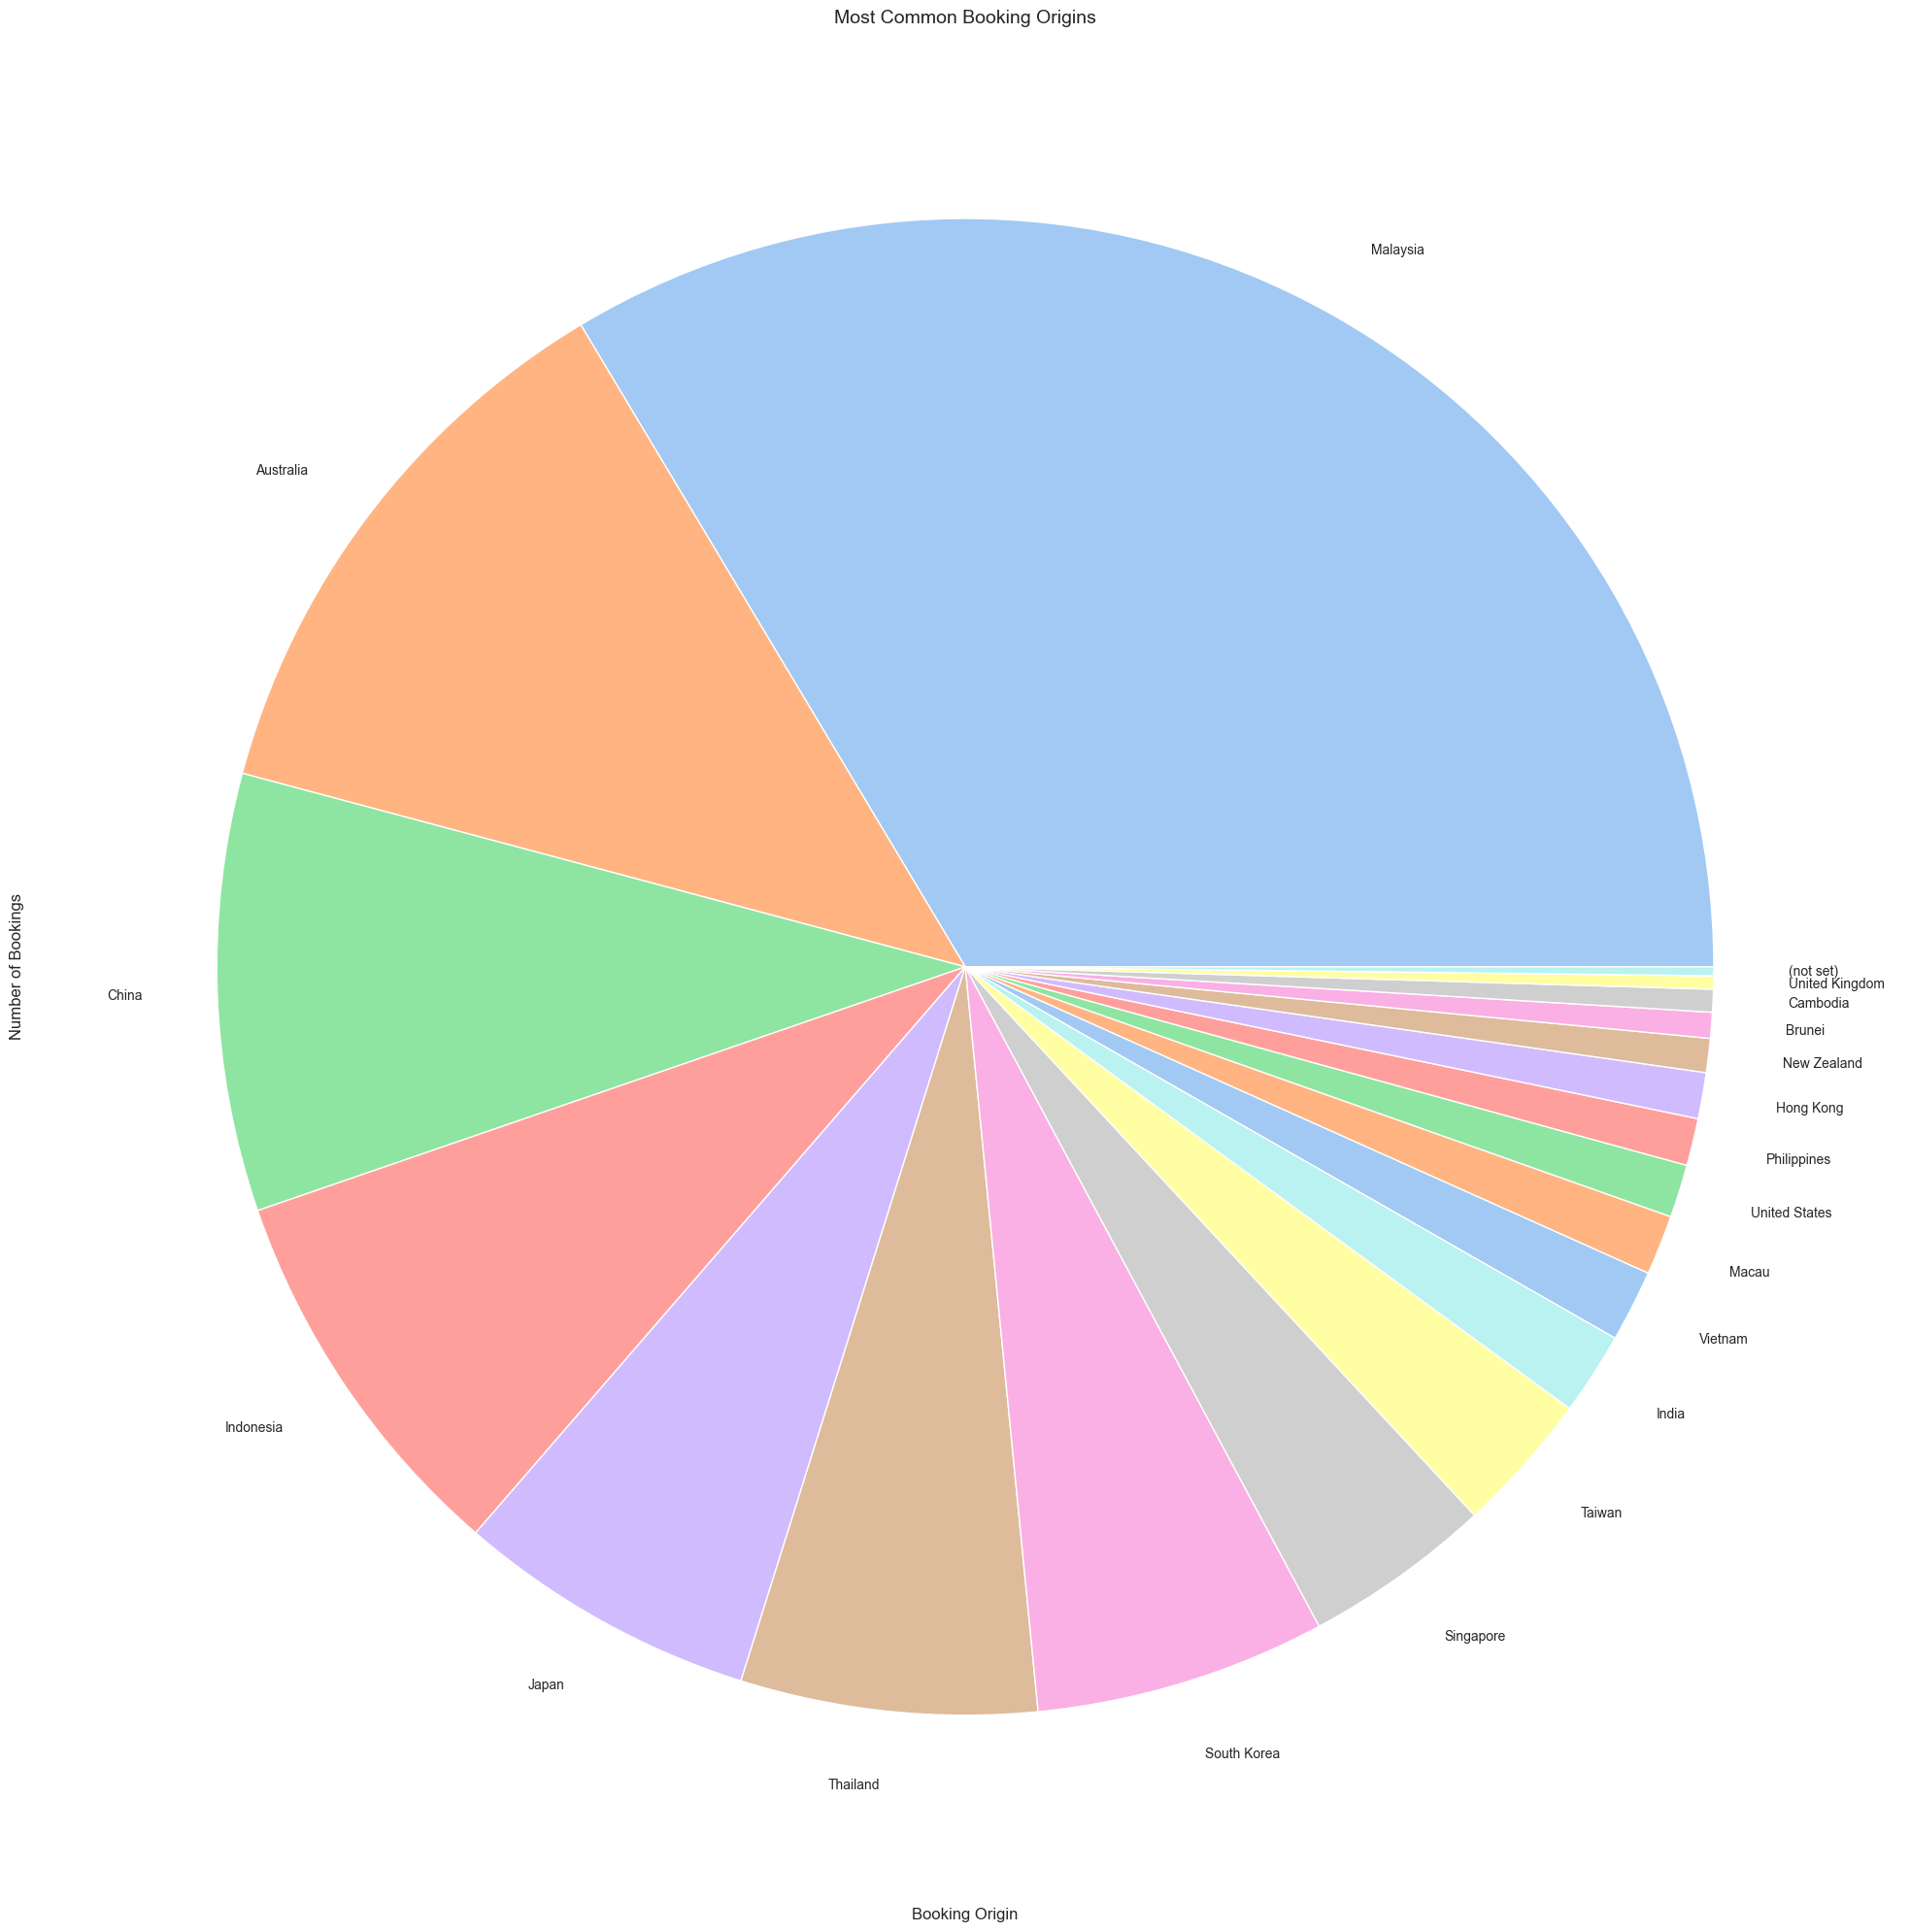

In [ ]:

booking_complete = df[df['booking_complete'] == 1]
most_booking_done = booking_complete['booking_origin'].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(20, 20))
most_booking_done.head(20).plot(kind='pie')
plt.xticks(fontsize=40)
plt.title('Most Common Booking Origins', fontsize=14)
plt.xlabel('Booking Origin', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)

plt.tight_layout()
plt.show()

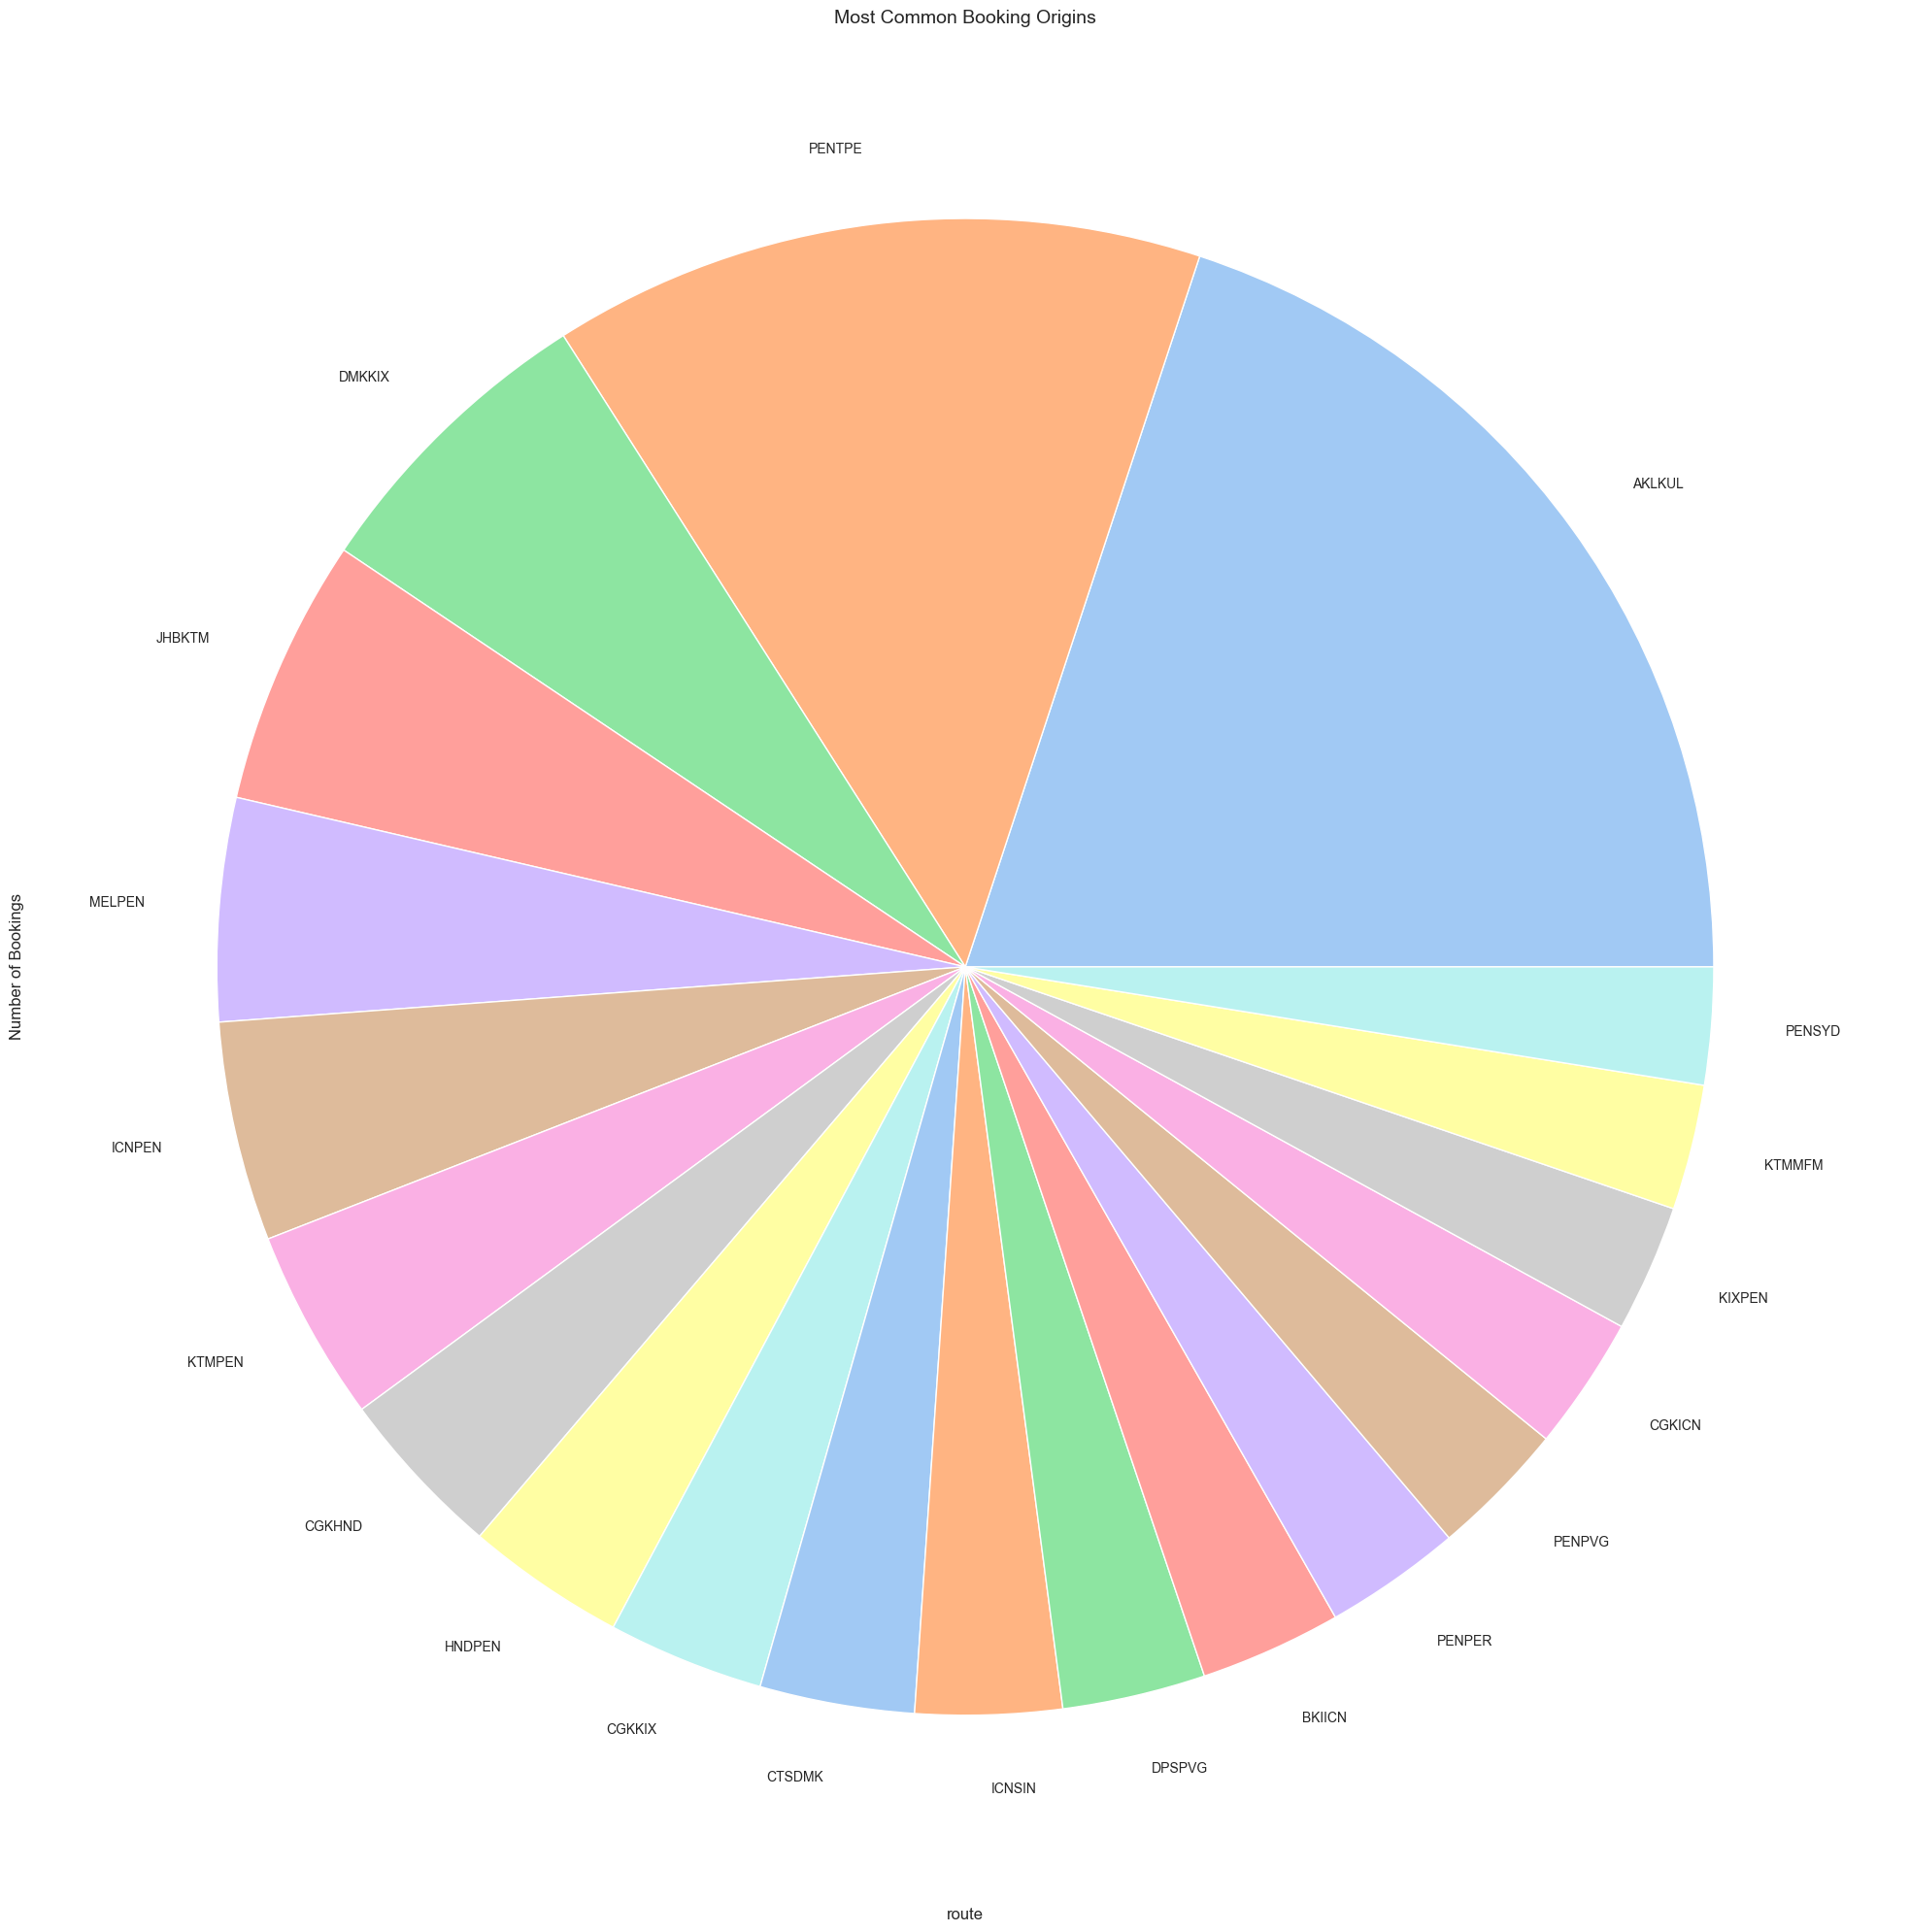

In [ ]:

booking_complete = df[df['booking_complete'] == 1]
most_booking_done = booking_complete["route"].value_counts()

sns.set_style('whitegrid')
sns.set_palette('pastel')

plt.figure(figsize=(20, 20))
most_booking_done.head(20).plot(kind='pie')
plt.xticks(fontsize=40)
plt.title('Most Common Booking Origins', fontsize=14)
plt.xlabel('route', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)

plt.tight_layout()
plt.show()

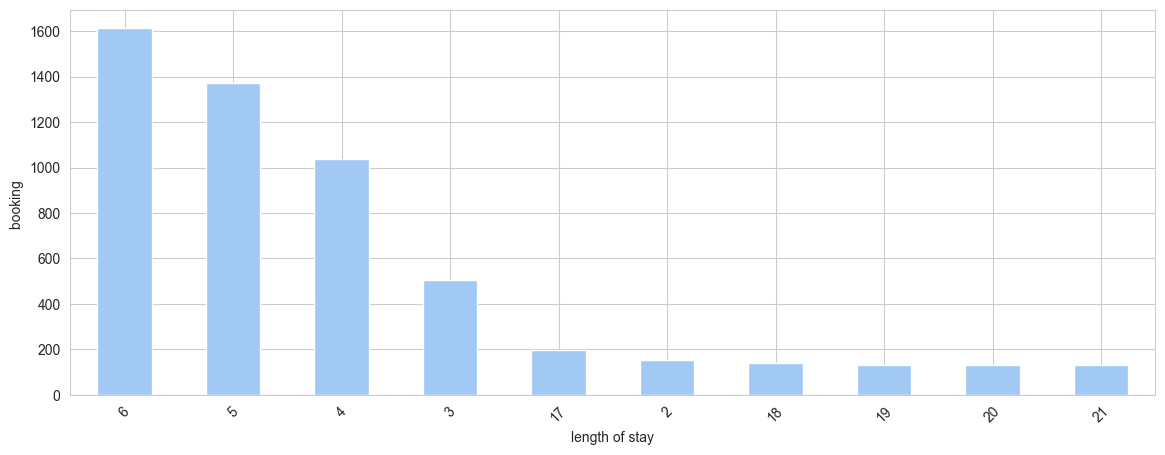

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
most_length_of_stay=complete["length_of_stay"].value_counts()
plt.figure(figsize=(14,5))
most_length_of_stay.head(10).plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel("length of stay")
plt.ylabel("booking ")
plt.show()

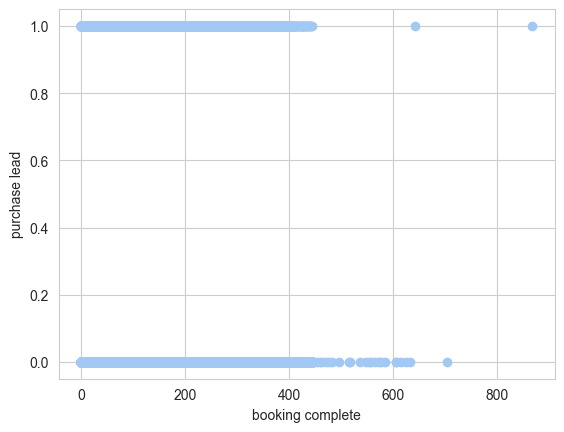

In [ ]:
plt.scatter(df['purchase_lead'],df['booking_complete'])
plt.xlabel("booking complete")
plt.ylabel("purchase lead")
plt.show()

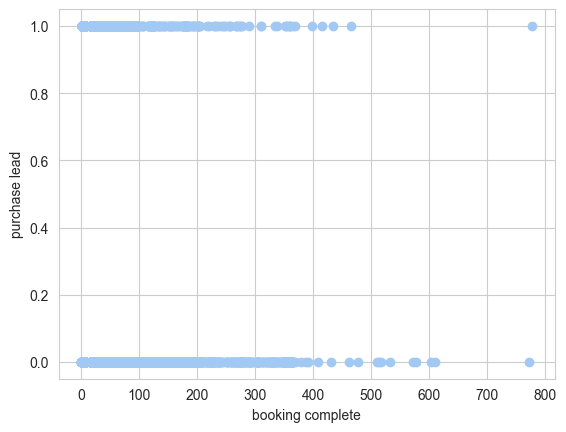

In [ ]:
plt.scatter(df['length_of_stay'],df['booking_complete'])
plt.xlabel("booking complete")
plt.ylabel("purchase lead")
plt.show()

# Mulltivariate Analysis 


In [ ]:
days_flight=complete['flight_day'].value_counts().index.to_list()
hours_df=complete[complete['flight_day']==1]
flight_hour=sorted(hours_df['flight_hour'].value_counts().index.to_list())
counts_hour=complete['flight_hour'].value_counts()
flight_hour_values={hour: count for hour,count in enumerate(counts_hour)}



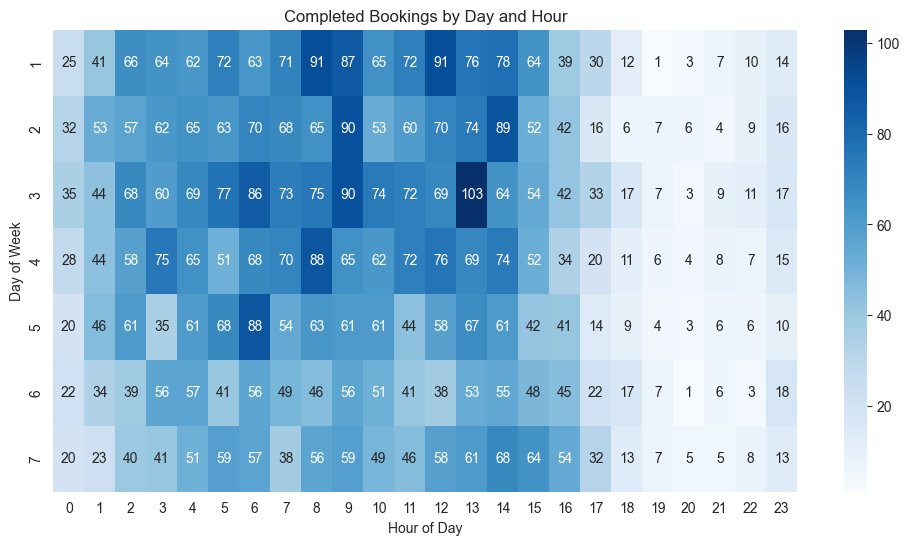

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


hour_booking=complete.groupby(['flight_day','flight_hour'])['booking_complete'].sum().reset_index()
top_hours=hour_booking.sort_values(by='booking_complete',ascending=False).head(40)


# Pivot for heatmap
pivot_table = hour_booking.pivot(index='flight_day', columns='flight_hour', values='booking_complete')

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".0f")
plt.title('Completed Bookings by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


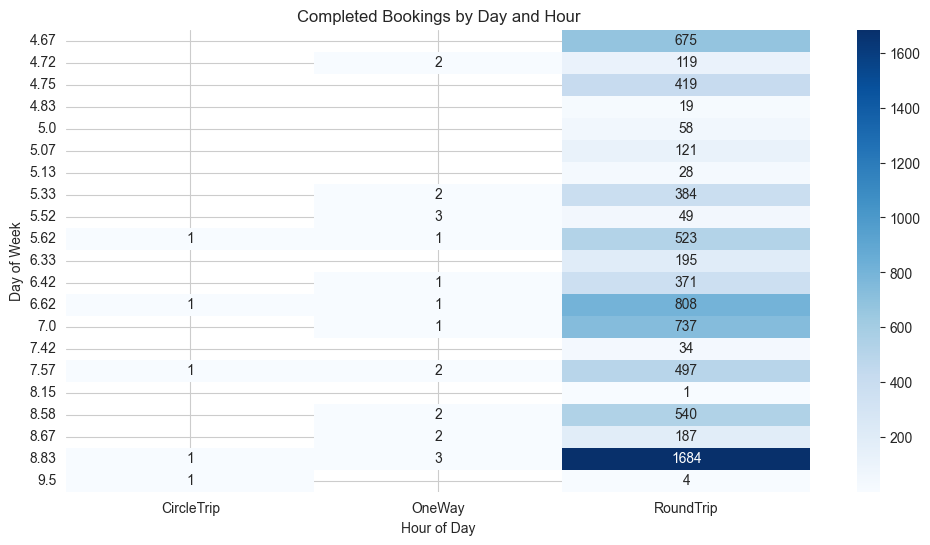

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


hour_booking=complete.groupby(['flight_duration','trip_type'])['booking_complete'].sum().reset_index()
top_hours=hour_booking.sort_values(by='booking_complete',ascending=False).head(40)


# Pivot for heatmap
pivot_table = hour_booking.pivot(index='flight_duration', columns='trip_type', values='booking_complete')

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".0f")
plt.title('Completed Bookings by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


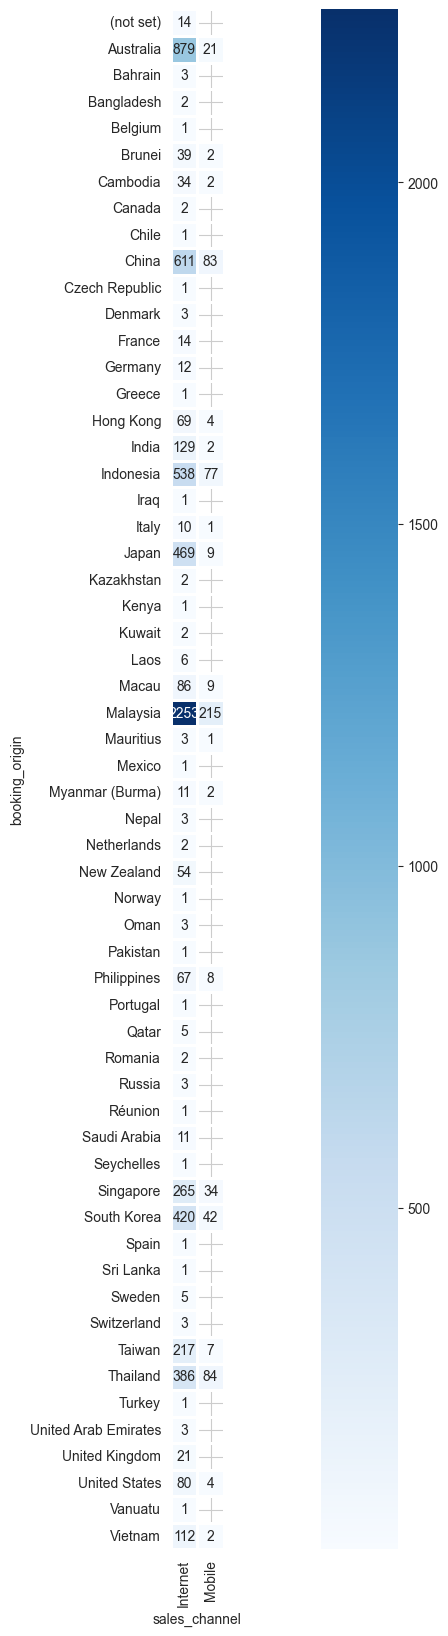

In [ ]:

# cross_tab = pd.crosstab(complete['booking_origin'], complete['route'])
# cross_tab = cross_tab.pivot(index='booking_origin', columns='route')
sales_booking=complete.groupby(['booking_origin','sales_channel'])['booking_complete'].sum().reset_index()
top_sales=sales_booking.sort_values(by='booking_complete',ascending=False).head(10)
filtered_sales=sales_booking[sales_booking['sales_channel'].isin(top_sales['sales_channel'])]
pivot_table = filtered_sales.pivot(index='booking_origin', columns='sales_channel', values='booking_complete')
pivot_table.fillna(0)

plt.figure(figsize=(25,20))
sns.heatmap(pivot_table, annot=True, cmap="Blues", fmt=".0f",linewidths=1, cbar=True, square=True) 
# linewidths=.5, cbar=True, square=True)
plt.show()


# routes_complete=complete.groupby(['booking_origin','route'])['booking_complete'].sum().reset_index()
# top_routes=routes_complete.sort_values(by='booking_complete',ascending=False).head(40)
# pivot_table=routes_complete.pivot_table(index='booking_origin',columns='route',values='booking_complete')
# plt.figure(figsize=(20, 20))
# sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".0f")
# plt.title('Completed Bookings by country of origin and route')
# plt.xlabel('routes booked')
# plt.ylabel('country booked from')
# plt.show()


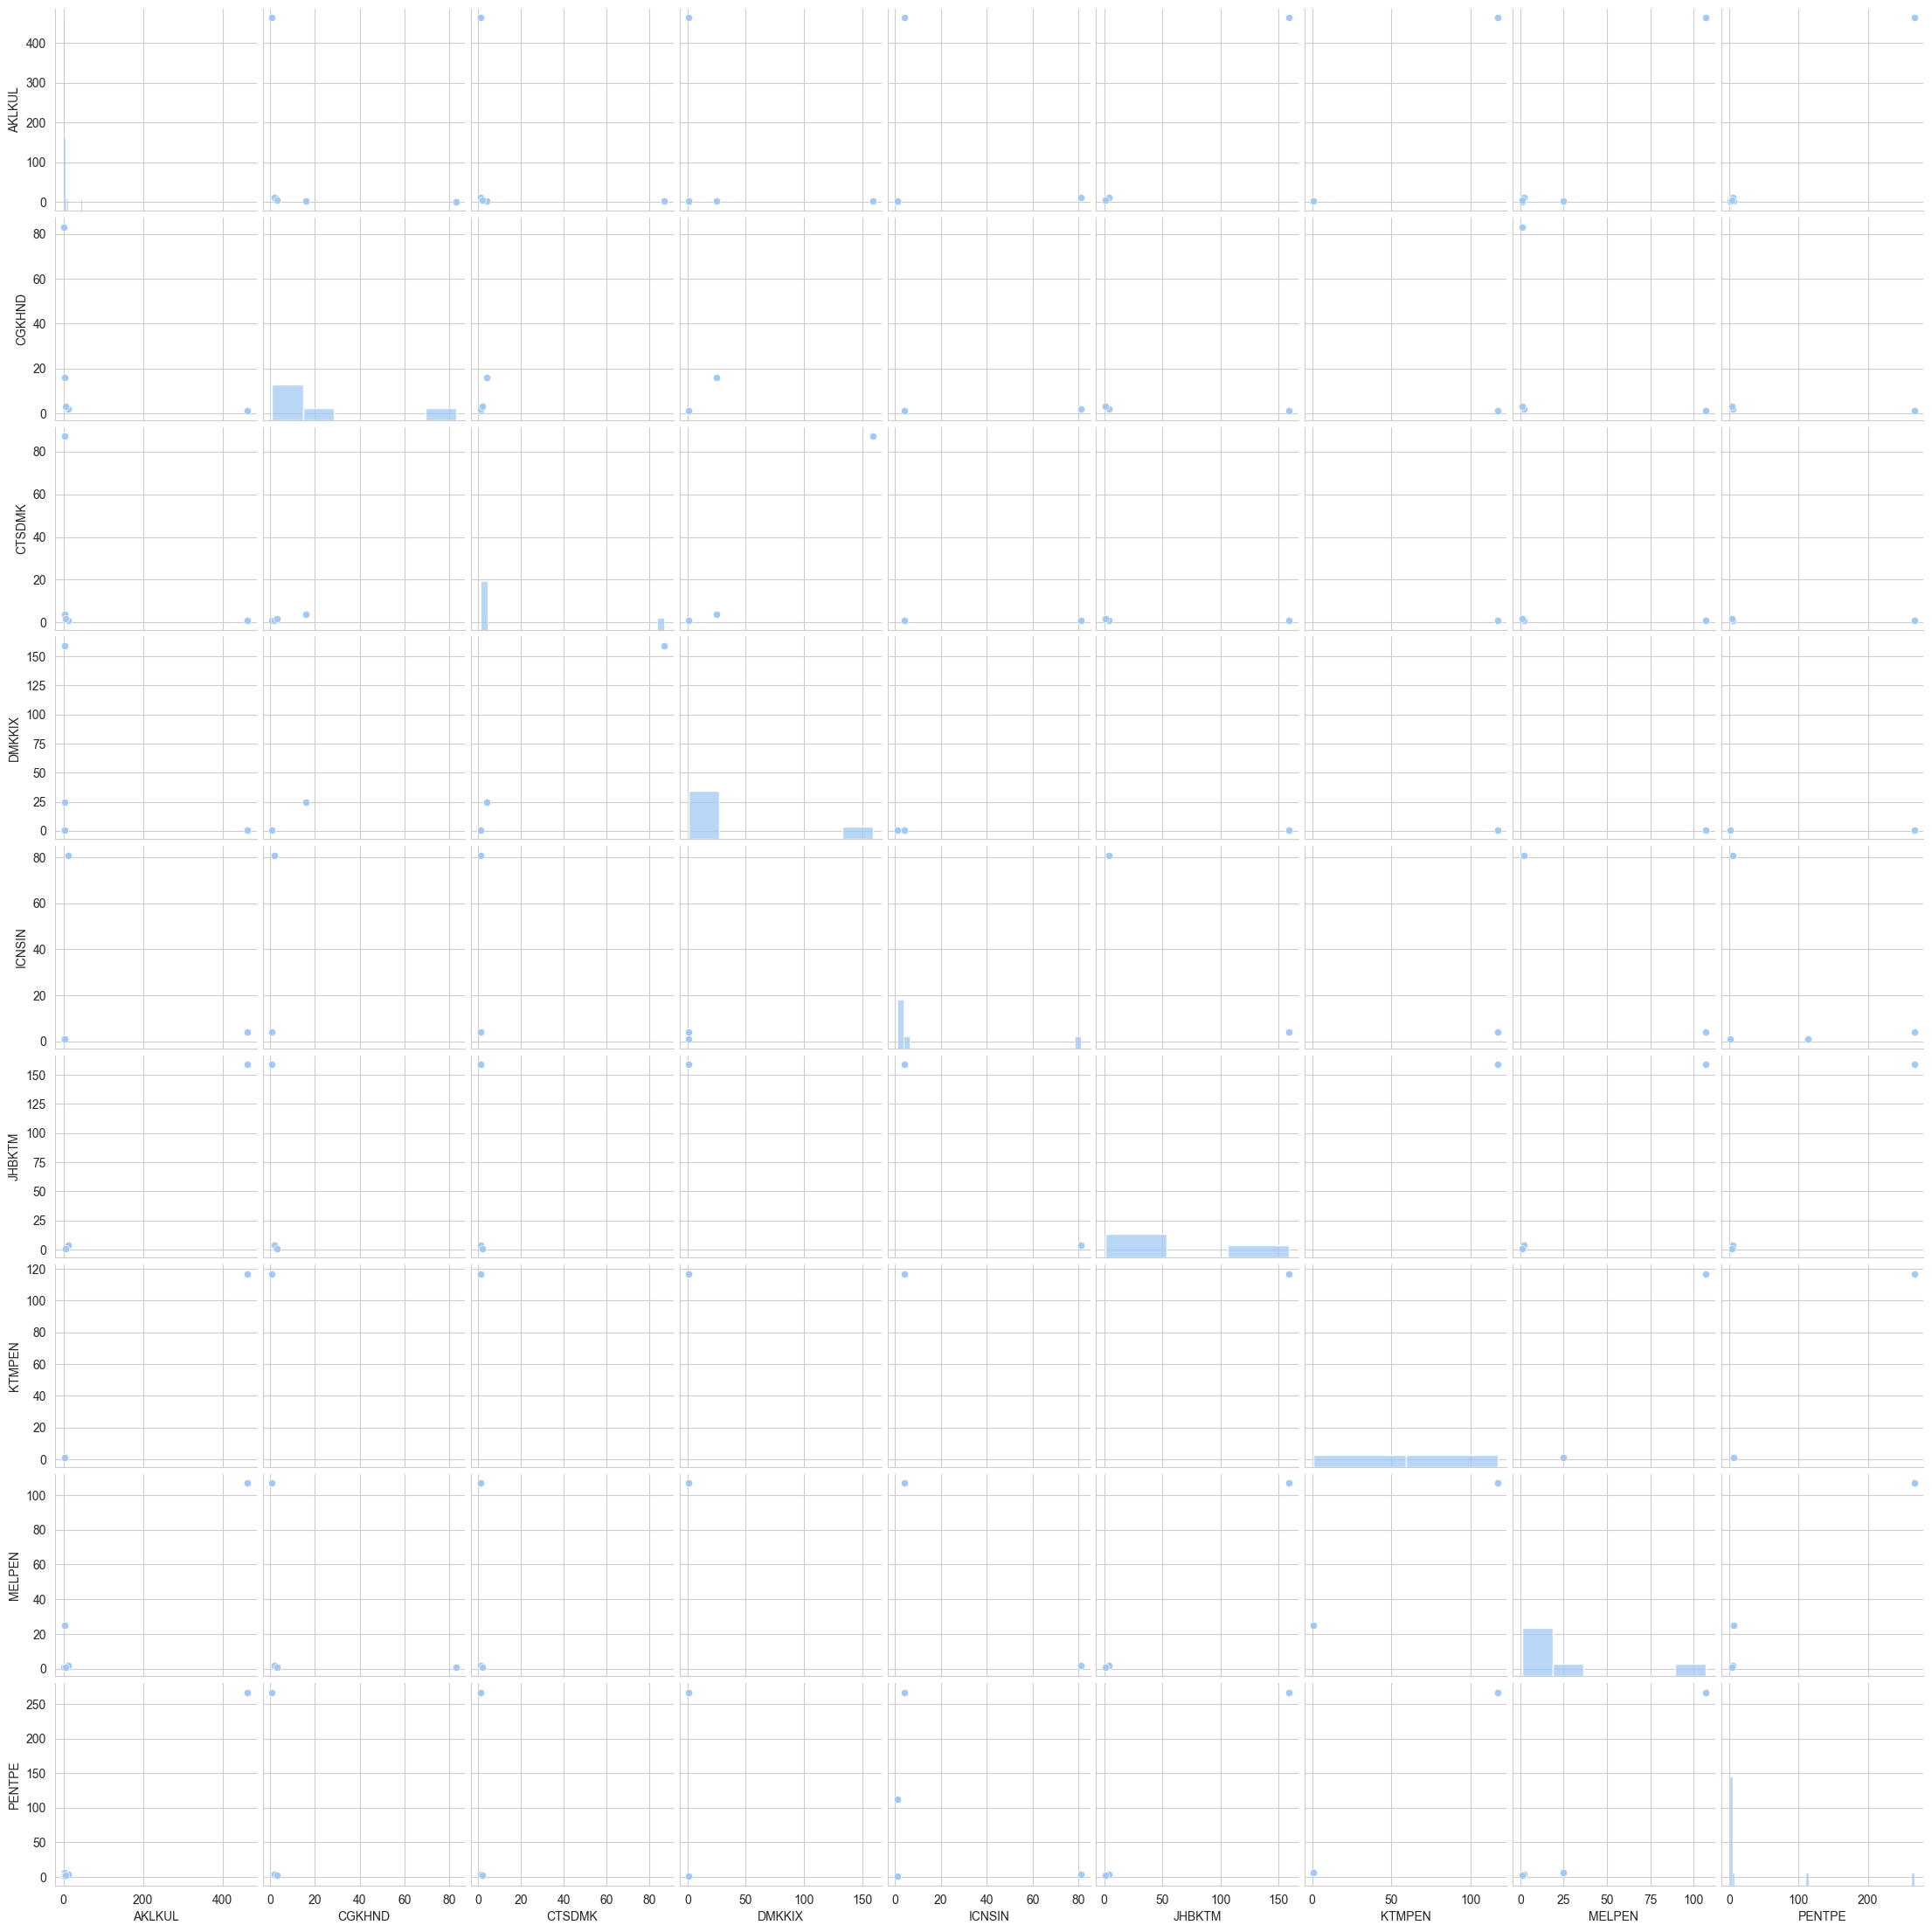

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Data (Replace with your actual DataFrame)
route_booking=complete.groupby(['booking_origin','route'])['booking_complete'].sum().reset_index()
top_routes=route_booking.sort_values(by='booking_complete',ascending=False).head(10)
filtered_routes=route_booking[route_booking['route'].isin(top_routes['route'])]
pivot_table = filtered_routes.pivot(index='booking_origin', columns='route', values='booking_complete')
pivot_table.fillna(0)
sns.pairplot(pivot_table)
plt.show()


In [ ]:
# import numpy as np
# from scipy.stats import chi2

# # Step 1: Observed frequencies
# observed = complete

# # Step 2: Row and column totals
# row_totals = observed.sum(axis=1)
# col_totals = observed.sum(axis=0)
# total = observed.sum()

# # Step 3: Expected frequencies
# expected = np.outer(row_totals, col_totals) / total

# # Step 4: Chi-square statistic
# chi_square_stat = ((observed - expected) ** 2 / expected).sum()

# # Step 5: Degrees of freedom
# dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)

# # Step 6: p-value
# p_value = 1 - chi2.cdf(chi_square_stat, dof)

# print("Chi-square statistic:", chi_square_stat)
# print("Degrees of freedom:", dof)
# print("p-value:", p_value)

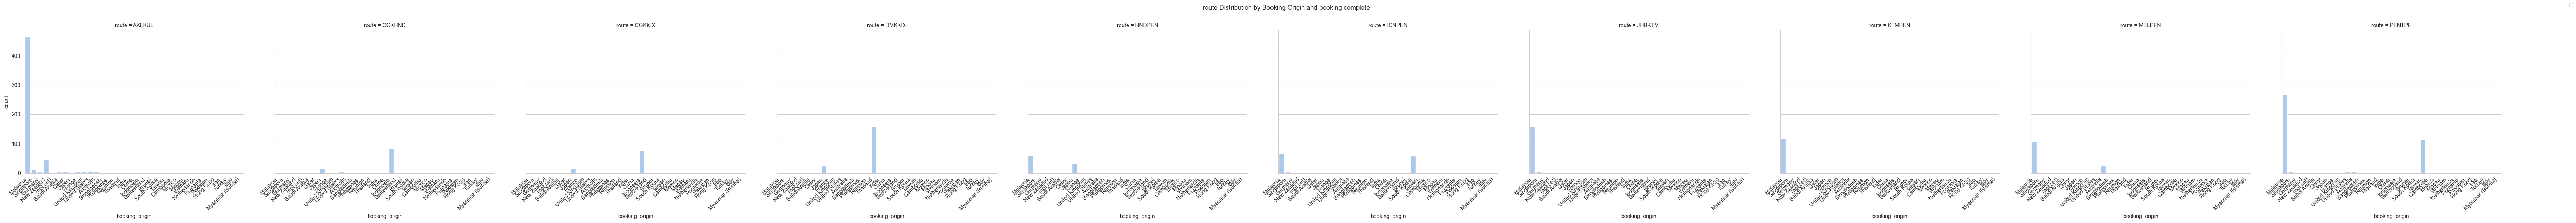

<Figure size 3000x3000 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


top_origins = (
    complete['booking_origin']
    .value_counts()
    .head(10)
    .index
)


top_routes=(complete['route']
    .value_counts()
    .head(10)
    .index)
filtered_df = complete[complete['booking_origin'].isin(top_origins)]
filtered_df = complete[complete['route'].isin(top_routes)]



g = sns.catplot(
    data=filtered_df,
    x='booking_origin',
    hue='booking_complete',
    col='route',
    kind='count',
    height=5,
    aspect=1.3
)


for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')


handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, loc='upper right')


g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("route Distribution by Booking Origin and booking complete")
plt.figure(figsize=(30,30))

plt.show()


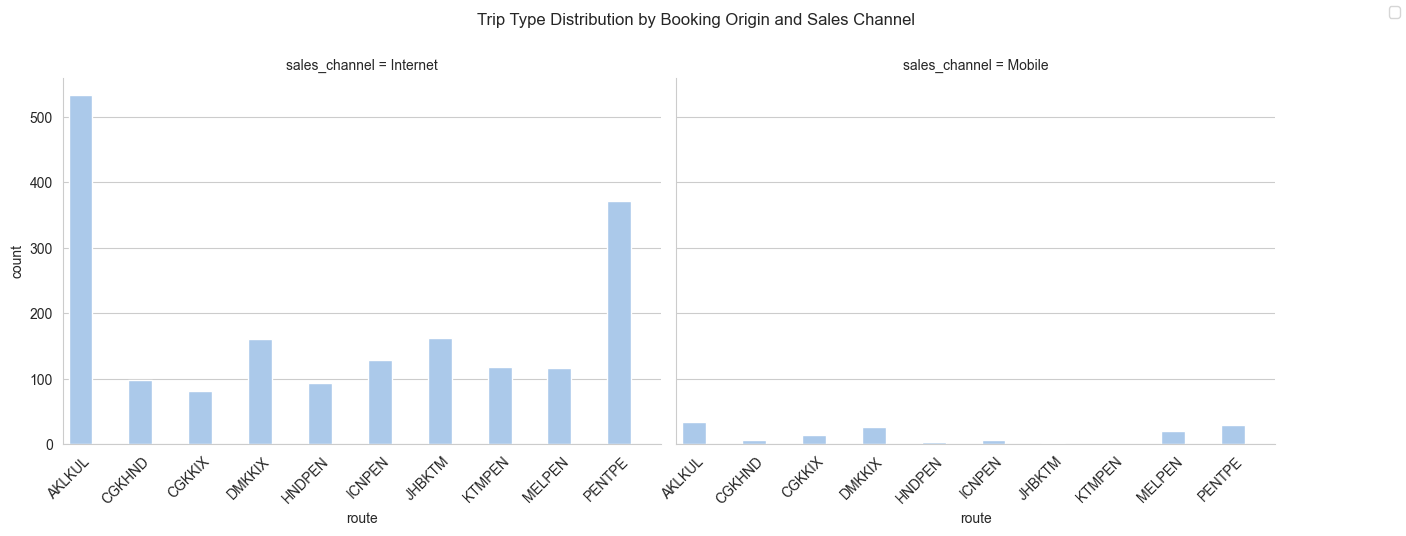

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


top_origins = (
    complete['route']
    .value_counts()
    .head(10)
    .index
)
top_routes


filtered_df = complete[complete['route'].isin(top_origins)]


g = sns.catplot(
    data=filtered_df,
    x='route',
    hue='trip_type',
    col='sales_channel',
    kind='count',
    height=5,
    aspect=1.3
)


for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')


handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, loc='upper right')


g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Trip Type Distribution by Booking Origin and Sales Channel")

plt.show()


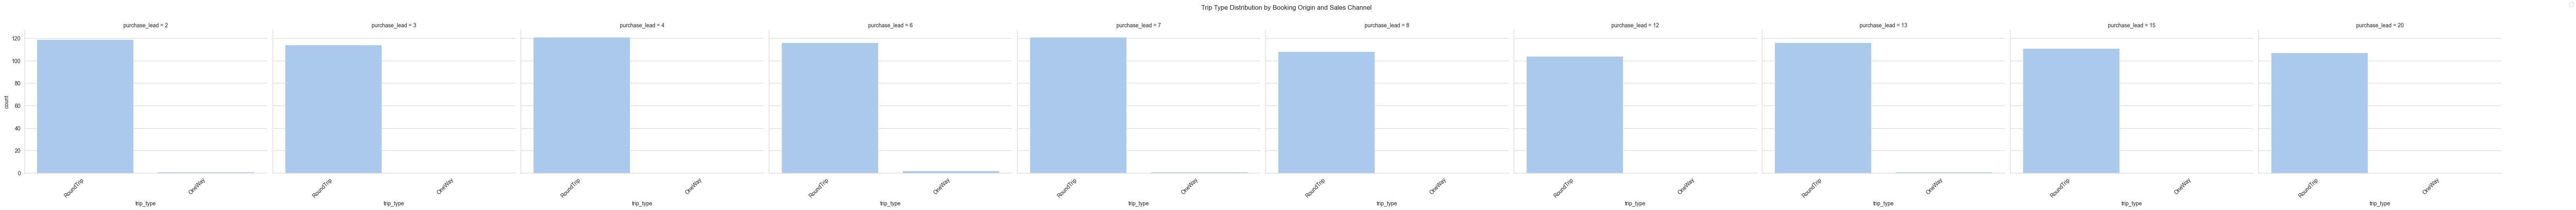

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


top_lead = (
    complete['purchase_lead']
    .value_counts()
    .head(10)
    .index
)
top_trip_type=(
    complete['trip_type']
    .value_counts()
    .head(10)
    .index
)


filtered_df = complete[complete['purchase_lead'].isin(top_lead)]
filtered_df=filtered_df[filtered_df['trip_type'].isin(top_trip_type)]


g = sns.catplot(
    data=filtered_df,
    x='trip_type',
    hue='booking_complete',
    col='purchase_lead',
    kind='count',
    height=5,
    aspect=1.3
)


for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')


handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, loc='upper right')


g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Trip Type Distribution by Booking Origin and Sales Channel")

plt.show()
